In [179]:
import pandas as pd
from tqdm import tqdm
import time
import litellm
import os
import numpy as np
tqdm.pandas()
#from .autonotebook import tqdm as notebook_tqdm
from sacrebleu.metrics import BLEU, CHRF, TER
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import random
random.seed(42)
from evaluate import load
bertscore = load("bertscore")
chrf = load("chrf")
sacrebleu = load("sacrebleu")

from litellm import completion
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
import json
from collections import Counter
from common import *
import Levenshtein
from sklearn.metrics import mean_squared_error
# Set the Seaborn style and color palette
sns.set_theme(style="whitegrid")
custom_palette = sns.color_palette("Set2")
import itertools
from collections import defaultdict

# Fluency evaluation

In this notebook, I have annotated up to 10 Europa translations per 15 long Flores sentences with a fluency rating, fluency errors, and the edited sentence. I excluded sentences with hallucinations such that even the dysfluent sentences with some flexibility can be said to encompass the same meaning as the source sentence. An excemption is lexical errors that are included, i.e. a model can output a sentence where a noun is replaced with a non-word or a wrong noun thereby completely changing the sematics of the sentence. These sentences are included. 

The aim is to find a model that is 
- able to distinguish fluent from dysfluent sentences-
- rate dysfluency
- rank sentences by dysfluency
- describe the fluency errors

We have up to ten fluent versions per source sentence. BLEU works better with multiple references

In [174]:
# set system variables
! source ~/.bashrc

# In this script, set the following variables
#export HUGGINGFACE_API_KEY=xxx
#export OPENAI_API_KEY=xxx
#export GEMINI_API_KEY=xxx
#export GOOGLE_APPLICATION_CREDENTIALS=/scratch/project_462000353/maribarr/.config/gcloud/application_default_credentials.json
#export HF_HOME=/scratch/project_462000353/cache


usage: huggingface-cli <command> [<args>]
huggingface-cli: error: unrecognized arguments: --add-to-git-credentials


## Create file for annotation

In [16]:
# make a set with the longest sentences for annotation 
flores200 = pd.read_json('/pfs/lustrep2/scratch/project_462000353/jburdge/git/compare_translations/flores/flores200_europa_eng_dan.jsonl', lines=True)

flores200['sentence_length'] = flores200['source_sentence'].str.len()

# Sort by this length
flores200_sorted = flores200.sort_values(by='sentence_length')

# If you want to sort in descending order (longest first)
flores200_sorted_desc = flores200.sort_values(by='sentence_length', ascending=False)

flores200_sorted_desc = flores200_sorted_desc.head(15)
sub = flores200_sorted_desc.explode('translations')

#sub = flores200.sample(15)
#sub = sub.explode('translations')
sub.to_csv('../data/flores200_subset_for_annotation.tsv', sep='\t', index=False)

In [6]:
df = pd.read_csv('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv', sep=',', index_col=None)

## Identify the fluent and the dysfluent version from pairwise comparison

In [178]:
df.to_csv('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv', sep=',', index=None)

In [ ]:
models = ['gpt-4-0125-preview', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']

cot = False

#models = ['gemini/gemini-2.0-flash', 'gemini/gemini-1.5-pro']
for model in models:
    df[f"{model}_{'cot' if cot else 'pairwise'}"] = df.progress_apply(lambda x: run_rating(translation = x['translations'], correction=x['Correction'], model=model, cot=cot, rating_prompt_func=create_rating_prompt), axis=1)
    #print(model, df[f'{model}_pairwise'].describe())"""
df.to_csv('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv', sep=',', index=None)
"""
cot = True
#models = ['gemini/gemini-2.0-flash', 'gemini/gemini-1.5-pro']
for model in models:
    df[f"{model}_{'cot' if cot else 'pairwise'}"] = df.progress_apply(lambda x: run_rating(translation = x['translations'], correction=x['Correction'], model=model, cot=cot, rating_prompt_func=create_rating_prompt, max_completion_tokens=1000), axis=1)
    #print(model, df[f'{model}_pairwise'].describe())
df.to_csv('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv', sep=',', index=None)"""

  0%|          | 0/100 [00:00<?, ?it/s]

translation:   Senere rapporter siger at flyet modtog end bomb trussel og m√•tte g√∏re en kvantespring tilbage til Afghanistan, hvorfra det landede i Kandahar.
correction:   Senere rapporter sagde s√• at flyet modtog en bombetrussel og m√•tte omdirigeres tilbage til Afghanistan, hvor det landede i Kandahar.


  2%|‚ñè         | 2/100 [00:05<04:25,  2.71s/it]

translation:   Senere rapporterer angiver, at flyet modtog en bombetrussel og blev omdirigeret hjem til Afghanistan, der lander i Kandahar.
correction:   Senere rapporterer angav s√•, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  3%|‚ñé         | 3/100 [00:10<05:59,  3.70s/it]

translation:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.


  4%|‚ñç         | 4/100 [00:14<06:20,  3.96s/it]

translation:   Senere rapporterer om √¶ndrede de, at flyet var blevet advaret om et muligt bombeanslag og vendte derefter tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporter sagde s√•, at flyet var blevet advaret om et muligt bombeangreb og det vendte derefter tilbage til Afghanistan og landede i Kandahar.


  5%|‚ñå         | 5/100 [00:21<07:51,  4.96s/it]

translation:   Senere rapporterede man om et bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporterede man om en bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.


  6%|‚ñå         | 6/100 [00:30<09:41,  6.19s/it]

translation:   Senere rapporter erkl√¶rede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, landing i Kandahar.
correction:   Senere rapporter erkl√¶rede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  7%|‚ñã         | 7/100 [00:35<09:03,  5.84s/it]

translation:   Efterretninger tilf√∏jede yderligere og sagde senere, at flyet fik en bombe trussel og blev afledt tilbage til Afghanistan, landing i Kandahar.
correction:   Efterretninger tilf√∏jede yderligere, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  8%|‚ñä         | 8/100 [00:42<09:37,  6.28s/it]

translation:   Senere rapporter bekr√¶ftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.
correction:   Senere rapporter bekr√¶ftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.


  9%|‚ñâ         | 9/100 [00:49<09:48,  6.47s/it]

translation:   Senere rapporter siger, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


 10%|‚ñà         | 10/100 [00:58<10:37,  7.09s/it]

translation:   Senere var der rapporter om, at flyet modtog en bombetruende melding og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.
correction:   Senere var der rapporter om, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.


 11%|‚ñà         | 11/100 [01:04<10:11,  6.88s/it]

translation:   Bekendtg√∏relsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Bekendtg√∏relsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.


 12%|‚ñà‚ñè        | 12/100 [01:09<09:13,  6.29s/it]

translation:   Udmeldelsen kom, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:   Udmeldingen kom, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 13%|‚ñà‚ñé        | 13/100 [01:16<09:17,  6.41s/it]

translation:   Bekendtg√∏relsen blev foretaget, efter at Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Bekendtg√∏relsen blev givet, efter at Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 14%|‚ñà‚ñç        | 14/100 [01:25<10:27,  7.29s/it]

translation:   Erkl√¶ringen blev fremsat efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:  Udmeldingen blev givet, efter at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 15%|‚ñà‚ñå        | 15/100 [01:31<09:45,  6.89s/it]

translation:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.


 16%|‚ñà‚ñå        | 16/100 [01:37<09:09,  6.54s/it]

translation:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 17%|‚ñà‚ñã        | 17/100 [01:42<08:40,  6.27s/it]

translation:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 18%|‚ñà‚ñä        | 18/100 [01:48<08:29,  6.21s/it]

translation:   Budskabet kom, da Trump havde telefonisk kontakt med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Udmeldingen  kom efter Trump havde telefonisk kontakt med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 19%|‚ñà‚ñâ        | 19/100 [01:57<09:25,  6.98s/it]

translation:   Meddelelsen kom efter, at Trump havde foretaget en telefonisk samtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:   Meddelelsen kom efter, at Trump havde foretaget en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 20%|‚ñà‚ñà        | 20/100 [02:05<09:43,  7.29s/it]

translation:   Deres termiske ‚Äã‚Äãadf√¶rd er ikke s√• stabil som store huler p√• jorden, der ofte holder en forholdsvis konstant temperatur, men det er konsistent, at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, lokaliseret i Flagstaff, Arizona.
correction:   Deres termiske ‚Äã‚Äãopf√∏rsel er ikke s√• stabil som store huler p√• jorden, der ofte holder en forholdsvis konstant temperatur, men det passer med at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 21%|‚ñà‚ñà        | 21/100 [02:11<08:58,  6.82s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som dybe huler p√• jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Unders√∏gelses (USGS) Astrogeologi Team og fra Northern Arizona University med base i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som dybe huler p√• jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Unders√∏gelses (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 22%|‚ñà‚ñà‚ñè       | 22/100 [02:19<09:15,  7.13s/it]

translation:   Deres termiske adf√¶rd er ikke s√• fast som p√• Jordens store huler (cave), som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybgrave i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.
correction:  Deres termiske opf√∏rsel er ikke s√• konsistent som i Jordens store huler, som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybe huller i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.


 23%|‚ñà‚ñà‚ñé       | 23/100 [02:24<08:18,  6.47s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det er konsekvent med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, som ligger i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det passer med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 24%|‚ñà‚ñà‚ñç       | 24/100 [02:32<08:57,  7.07s/it]

translation:   Deres termiske adf√¶rd (temperaturudvikling) er ikke s√• konstant som i store huler p√• Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden.
correction:  Deres termiske opf√∏rsel er ikke s√• konstant som i store huler p√• Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden, sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona..


 25%|‚ñà‚ñà‚ñå       | 25/100 [02:38<08:33,  6.84s/it]

translation:   Temperaturen svinger ikke lige s√• meget i dem som i store huler p√• Jorden, men den er i tr√•d med det, at de har v√¶ret dybe gruber i jorden,‚Äù fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, som har base i Flagstaff, Arizona.
correction:   Temperaturen svinger mere i dem end i store huler p√• Jorden, men den er i tr√•d med det, at de er dybe gruber i jorden,‚Äù fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, Flagstaff, Arizona.


 26%|‚ñà‚ñà‚ñå       | 26/100 [02:45<08:17,  6.72s/it]

translation:   Deres termiske adf√¶rd er ikke s√• konstant som de store huler p√• jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, der ligger i Flagstaff , Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• konstant som de store huler p√• jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, Flagstaff , Arizona.


 27%|‚ñà‚ñà‚ñã       | 27/100 [02:52<08:12,  6.75s/it]

translation:   Den termiske adf√¶rd er ikke s√• stabil som hulerne p√• Jorden, som ofte fastholder en n√¶sten konstant temperatur, men det er i overensstemmelse med disse dybhuller i jorden,¬´ siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   De termiske observationer er ikke s√• stabile som i de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden,¬´ siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 28%|‚ñà‚ñà‚ñä       | 28/100 [02:56<07:23,  6.15s/it]

translation:   Den termiske adf√¶rd er ikke s√• stabil som store huler p√• Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tr√•d med dem er dybe huller i jorden," sagde Glen Cushing fra de Forenede USA Geologiske Survey (USGS) Astrogeologi Team og p√• Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Den termiske opf√∏rsel er ikke s√• stabil som store huler p√• Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tr√•d med at disse er dybe huller i jorden," sagde Glen Cushing fra USA's Geologiske Survey (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 29%|‚ñà‚ñà‚ñâ       | 29/100 [03:03<07:17,  6.16s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som store huler p√• Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse at v√¶re dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Unders√∏gelse (USGS) Astrogeologi Hold og fra Northern Arizona Universitet ligger i Flagstaf, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som store huler p√• Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Unders√∏gelse (USGS) Astrogeologi Team og fra Northern Arizona Universitet, Flagstaf, Arizona.


 30%|‚ñà‚ñà‚ñà       | 30/100 [03:11<07:48,  6.69s/it]

translation:   Deres termiske opf√∏rsel er ikke s√• konstant som dybe, store huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe, huler i jorden, sagde Glen Cushing fra USGS‚Äôs Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• konstant som dybe, store huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe huler i jorden, sagde Glen Cushing fra USGS‚Äôs Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.


 31%|‚ñà‚ñà‚ñà       | 31/100 [03:15<06:52,  5.97s/it]

translation:   Deres termiske opf√∏rsel er ikke s√• stabil som st√∏rre huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som st√∏rre huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 32%|‚ñà‚ñà‚ñà‚ñè      | 32/100 [03:23<07:35,  6.69s/it]

translation:   Den faste sekret√¶r for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde p√• mandag under et radioprogram for Sveriges Radio i Sverige p√• Sveriges Radio, at komiteen, som manglede evne til at rette kontakten til Bob Dylan for at gratulere ham med Nobelprisen i Litteratur for 2016et, havde opgivet fors√∏gene p√• at n√• ham.
correction:   Den permanente sekret√¶r for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde i mandags under et radioprogram for Sveriges Radio, at komiteen, som ikke havde kunnet f√• kontakt til Bob Dylan for at lyk√∏nske ham med Nobelprisen i Litteratur i 2016, havde opgivet fors√∏gene p√• at kontakte ham.


 33%|‚ñà‚ñà‚ñà‚ñé      | 33/100 [03:31<07:48,  6.99s/it]

translation:   P√• mandag meddelte Sara Danius, permanent sekret√¶r ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram p√• Sveriges radio i Sverige, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Dylan, opgav at videref√∏re sine bestr√¶belser p√• at n√• ham.
correction:  I mandags meddelte Sara Danius, permanent sekret√¶r ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram p√• Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Bob Dylan, havde opgivet at kontake ham ham.


 34%|‚ñà‚ñà‚ñà‚ñç      | 34/100 [03:37<07:14,  6.58s/it]

translation:   MANDAG offentliggjorde Sara Danius, permanent sekret√¶r for Nobelkomiteen for Litteratur ved det svenske Akademi, p√• en radiosending p√• Sveriges Radio i Sverige, at Nobelkomiteen for Litteratur, ude af stand til at f√• fat i Bob Dylan direkte, for at overr√¶kke ham Nobelprisen i litteratur for 2016, havde ladet sine anstrengelser for at f√• fat i ham falde.
correction:   MANDAG offentliggjorde Sara Danius, permanent sekret√¶r for Nobelkomiteen for Litteratur ved det Svenske Akademi, i en radioudsendelse p√• Sveriges Radio, at Nobelkomiteen for Litteratur, der var ude af stand til at f√• fat i Bob Dylan for at overr√¶kke ham Nobelprisen i litteratur for 2016, havde opgivet at kontakte ham.


 35%|‚ñà‚ñà‚ñà‚ñå      | 35/100 [03:44<07:15,  6.71s/it]

translation:   Sara Danius, permanent sekret√¶r for Nobelkomiteen for litteratur ved Svenska Akademin, meddelte p√• et radioprogram af Sveriges Radio i Sverige, at Nobelkomiteen, ude af stand til at n√• Bob Dylan direkte ang√•ende inds√¶ttelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekret√¶r for Nobelkomiteen for litteratur ved Svenska Akademien, meddelte p√• et radioprogram af Sveriges Radio, at Nobelkomiteen, der var ude af stand til at kontakte Bob Dylan ang√•ende overr√¶kkelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.


 36%|‚ñà‚ñà‚ñà‚ñå      | 36/100 [03:49<06:45,  6.34s/it]

translation:   Sara Danius, sekret√¶r permanent i Nobelkomit√©en for Litteratur ved Svenska Akademien, offentliggjorde mandag i radioen Sveriges radio, at komit√©en, ikke var i stand til at snakke med Bob Dylan vedr√∏rende Nobelprisen i litteratur 2016, havde opgivet sit fors√∏g p√• at snakke med ham.
correction:   Sara Danius, permanent sekret√¶r i Nobelkomit√©en for Litteratur ved Svenska Akademien, offentliggjorde mandag i Sveriges Radio, at komit√©en ikke var i stand til at kontakte med Bob Dylan vedr√∏rende Nobelprisen i litteratur 2016, og nu havde opgivet sit fors√∏g p√• at komme i kontakt med ham.


 37%|‚ñà‚ñà‚ñà‚ñã      | 37/100 [03:53<06:01,  5.74s/it]

translation:   P√• mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpris-komit√©en for litteratur ved den Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, der ikke har haft mulighed for at n√• Bob Dylan direkte vedr√∏rende hans modtagelse af Nobelprisen i litteratur i 2016, derfor havde opgivet at g√∏re dette.
correction:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpris-komit√©en for litteratur ved det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, der ikke har form√•et at komme i kontakt med Bob Dylan vedr√∏rende hans modtagelse af Nobelprisen i litteratur i 2016, nu har opgivet dette.


 38%|‚ñà‚ñà‚ñà‚ñä      | 38/100 [04:00<06:16,  6.07s/it]

translation:   Mandag annoncerede Sara Danius, permanent sekret√¶r for Nobelkomit√©en for Litteratur hos den Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, ude af stand til at komme i kontakt med Bob Dylan, opgav at fors√∏ge at kontakte ham.
correction:   Mandag annoncerede Sara Danius, permanent sekret√¶r for Nobelkomit√©en for Litteratur hos det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, ude af stand til at komme i kontakt med Bob Dylan, nu opgav at fors√∏ge at kontakte ham.


 39%|‚ñà‚ñà‚ñà‚ñâ      | 39/100 [04:08<06:36,  6.49s/it]

translation:   Sara Danius, permanent sekret√¶r i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram p√• Sveriges Radio i Sverige, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekret√¶r i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram p√• Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.


 40%|‚ñà‚ñà‚ñà‚ñà      | 40/100 [04:16<06:59,  6.99s/it]

translation:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpriskomit√©en for Litteratur i Svenska Akademien, p√• Sveriges Radio i Sverige, i et radioprogram, at komit√©en, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet fors√∏get p√• at genoprette kontakten med ham.
correction:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpriskomit√©en for Litteratur i Svenska Akademien, p√• Sveriges Radio, i et radioprogram, at komit√©en, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet fors√∏get p√• at opn√• kontakt til ham.


 41%|‚ñà‚ñà‚ñà‚ñà      | 41/100 [04:26<07:56,  8.08s/it]

translation:   Mandag meddelte Sara Danius, permanent sekret√¶r for Nobelkomit√©en for litteratur hos den Svenske Akademien, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, ikke i stand til direkte at f√• kontakt til Bob Dylan, havde opgivet sit fors√∏g p√• at kontakte ham.
correction:   Mandag meddelte Sara Danius, permanent sekret√¶r for Nobelkomit√©en for litteratur hos det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, der ikke var i stand til at f√• kontakt til Bob Dylan, havde opgivet sit fors√∏g p√• at kontakte ham.


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 42/100 [04:35<07:55,  8.19s/it]

translation:   Som NSA assisterede Carter i diplomatisk h√•ndtering af verdens anliggender, s√•som Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der f√∏rte til gidselkrisen i Iran i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA assisterede han Carter i diplomatisk h√•ndtering af verdens anliggender, s√•som Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 43/100 [04:44<07:59,  8.42s/it]

translation:   Som NSA, hjalp han Carter med diplomatisk at styre verdenssager, s√•som Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som led til den iranske gidselsituation i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med diplomatisk at styre verdensanliggender, s√•som Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som f√∏rte  til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 44/100 [04:48<06:44,  7.23s/it]

translation:   Som NSA, hjalp han Carter i diplomatisk h√•ndteringen af verdens anliggender, s√•som forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som f√∏rte til Iransk gidseldrama i 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, hjalp han Carter i diplomatisk h√•ndteringen af verdens anliggender, s√•som forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan, 1979.


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 45/100 [04:56<06:42,  7.32s/it]

translation:   Som NSA samarbejdede han med Carter om at h√•ndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA‚ÄìKina forhold i slutningen af 1970'erne; den iranske revolution, som f√∏rte til Iran-gisler-situationen i 1979; og den sovjetiske invasion i 1979.
correction:   Som NSA samarbejdede han med Carter om at h√•ndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA‚ÄìKina forhold i slutningen af 1970'erne; den iranske revolution, som f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion af Afghanistan i 1979.


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 46/100 [05:02<06:14,  6.93s/it]

translation:   Som NSA, han bistod Carter med h√•ndtering diplomatiske anliggender i verden, s√•som Camp David-aftalerne, 1978; at normalisere USA-Kina relationer i slutningen af 1970'erne; den iranske revolution, der f√∏rte til Irans gidseldrama, 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, bistod han Carter med h√•ndtering diplomatiske anliggender i verden, s√•som Camp David-aftalen, 1978; at normalisere USA-Kina-relationen i slutningen af 1970'erne; den iranske revolution, der f√∏rte til Iran-gidsel-aff√¶ren, 1979; og den sovjetiske invasion i Afghanistan, 1979.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 47/100 [05:12<06:53,  7.81s/it]

translation:   Som NSA, hjalp han Carter med at manipulere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; med hensyn til at normalisere americanaftale med Kina i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselikrise og en sovjetisk invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med at h√•ndtere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; normalisere forholdet mellem  USA og Kina  i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselkrise og den sovjetiske invasion i Afghanistan i 1979.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 48/100 [05:20<06:49,  7.88s/it]

translation:   Som NSA, bidrog han til Carters diplomatiske h√•ndtering af internationale problemer s√•som Camp David-aftalerne fra 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der f√∏rte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.
correction:   Som NSA, bidrog han til Carters diplomatiske h√•ndtering af internationale problemer s√•som Camp David-aftalen i 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der f√∏rte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 49/100 [05:25<06:03,  7.13s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afg√∏re, hvorvidt der er en vej frem for mig i dette l√∏b", men sagde senere, at han ville blive i racet og konkurrere i South Carolina prim√¶rvalget den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afg√∏re, hvorvidt der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville forts√¶tte sin kampagne og stille op i South Carolina prim√¶rvalget den 21. januar.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 50/100 [05:30<05:15,  6.30s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, bestemme om der er en vej frem for mig i dette valg og" senere sagde, at han ville blive og konkurrere i prim√¶rvalget i South Carolina den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, og se om der er en vej frem for mig i dette valg og" senere sagde han, at han ville blive og stille op i prim√¶rvalget i South Carolina den 21. januar.


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 51/100 [05:37<05:18,  6.51s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til dette l√∏b," men han fortalte senere, han ville blive i l√∏bet og konkurrere i den indledende runde i South Carolina den 21 januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til denne valgkamp," men han fortalte senere, han ville blive i valgkampen og stille op i den indledende runde i South Carolina den 21 januar.


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 52/100 [05:43<05:16,  6.59s/it]

translation:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgm√∏de, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville forts√¶tte i valget og konkurrere i prim√¶rvalget i South Carolina den 21. januar).
correction:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgm√∏de, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville forts√¶tte i valget og g√• efter sejren i prim√¶rvalget i South Carolina den 21. januar.


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 53/100 [05:49<04:52,  6.23s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og fastl√¶gge, om der er en vej for mig selv i dette l√∏b", men sagdere senere, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget den 21. januar i South Carolina.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og beslutte, om der er en vej for mig selv i dette valg", men sagde senere, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget den 21. januar i South Carolina.


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 54/100 [05:55<04:51,  6.34s/it]

translation:   Perry angav, at han ville "vende tilbage til Texas for at bed√∏mme resultaterne af natternes caucus, for at fastsl√• om der er en sti frem for mig i denne valgkamp", men sagde senere, at han ville blive i l√∏bet og stille op i den 21. januar i Syd Carolina.
correction:   Perry angav, at han ville "vende tilbage til Texas for at bed√∏mme resultaterne af natternes caucus, for at fastsl√• om der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville blive i valgkampen og stille op i den 21. januar i South Carolina.


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 55/100 [06:03<05:00,  6.69s/it]

translation:   Perry erkl√¶rede, at han ville "vende tilbage til Texas for at vurdere resultaterne af tonight's caucus, bestemme om der er en vej fremad for mig i l√∏bet", men han senere ville forblive i indtr√¶kningen og konkurrere i den South Carolina prim√¶r den 21. januar.
correction:   Perry erkl√¶rede, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, bestemme om der er en vej fremad for mig i valgkampen", men han sagde senere ville forblive i valgkampen og stille op i  South Carolina prim√¶rvalg den 21. januar.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 56/100 [06:09<04:52,  6.65s/it]

translation:   Perry meddelte, at han ville "komme tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re, om der var er en mulig sti for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen og konkurrere i den 21. januars prim√¶rvalg i South Carolina.
correction:   Perry meddelte, at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re om der var er en mulig vej frem for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen om prim√¶rvalget i South Carolina d. 21. januar.


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 57/100 [06:16<04:47,  6.70s/it]

translation:   Perry sagde at hun ville "returne to Texas to assess te outcomes of tonight's caucus, determine whether there is a path forward for myself in this race", men senere sagde hun at hun ville blive i konkurrencen og deltage i den Syd Carolina v√¶lgerkonvent den 21 januar.
correction:   Perry sagde at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re om der var er en mulig vej frem for mig i denne valgkamp", men senere sagde han at han ville blive i valgkampen og deltage i prim√¶rvalget i South Carolina d. 21 januar.


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 58/100 [06:23<04:43,  6.76s/it]

translation:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremgangsm√•de for mig i dette l√∏b, men har senere udtalt, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget i South Carolina den 21 januar.
correction:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremtid for mig i denne valgkamp, men har senere udtalt, at han ville blive i kampen deltage i prim√¶rvalget i South Carolina den 21 januar.


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 59/100 [06:29<04:23,  6.43s/it]

translation:   Siden da det f√∏derale styre har grebet ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsstaten Australien og nogle f√∏derale medlemmer af parlamentet h√¶vdet, at det er en gennemf√∏rt stunt i begyndelsen p√• en planlagt zvezds-kampagne til valget til Repr√¶sentanternes Hus, som afholdes i november.
correction:   Siden det f√∏derale styre greb ind for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsstaten og nogle parlamentetsmedlemmer h√¶vdet, at det er et gennemf√∏rt stunt inden valget til Repr√¶sentanternes Hus, som afholdes i november.


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 60/100 [06:36<04:25,  6.65s/it]

translation:   Siden den f√∏derale regering tr√•dte ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte f√¶llesrepr√¶sentanter kritiseret denne handling som et stunt i prelude til det f√∏derale valg til at blive indkaldt til november.
correction:   Siden den f√∏derale regering tr√•dte ind for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte parlamentsmedlemmer kritiseret denne handling som et stunt i optakten til det f√∏derale valg i november.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 61/100 [06:42<04:12,  6.46s/it]

translation:   Siden forbundsregeringen tr√•dte til og overtog statens fortsatte st√∏tte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det f√∏derale valg, der skal afholdes inden november.
correction:   Siden forbundsregeringen tr√•dte til og overtog statens fortsatte st√∏tte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det f√∏derale valg, der skal afholdes inden november.


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 62/100 [06:48<03:56,  6.22s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som en del af peron√¶vnelsen til de f√∏derale valg, der vil blive afholdt inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt inden de f√∏derale valg, der vil blive afholdt inden november.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 63/100 [06:53<03:45,  6.09s/it]

translation:   Siden den f√∏derale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle f√∏derale lovgivere v√¶ret ude og stramme munden med kritik af dette stunt som en bebuden aktion i forspillet til et valg til november.
correction:   Siden den f√∏derale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle f√∏derale lovgivere v√¶ret ude med kritik af dette stunt som et forspil til et valg til november.


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 64/100 [07:02<04:01,  6.71s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af f√∏derale parlamentsmedlemmer kritiseret denne handling som et statmandstrick foran den f√∏deralvalg, der skal finde sted i november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt foran den f√∏deralvalg, der skal finde sted i november.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 65/100 [07:09<04:07,  7.08s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af ‚Äã‚ÄãMersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget i indledningen til det f√∏derale valg til at blive kaldt inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af ‚Äã‚ÄãMersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget inden det f√∏derale valg, der skal udskrives inden november.


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 66/100 [07:14<03:38,  6.41s/it]

translation:   Siden forbundsregeringen tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt i overd√¶kket til forbundsvalget bliver er det kan det.
correction:   Siden forbundsregeringen tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt inden det f√∏derale valg, der skal udskrives inden november.


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 67/100 [07:22<03:40,  6.70s/it]

translation:   Siden det f√∏derale regering siden er tr√•dte i at overtage finansiering af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret dette som et stunt i overblikket over den f√∏derale valg, der skal kaldes af november.
correction:  Lige siden det f√∏derale regering tr√•dte til for at overtage finansiering af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret dette som et stunt i k√∏lvandet p√• det  f√∏derale valg, der skal udskrives inden november.


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 68/100 [07:28<03:35,  6.74s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentariske repr√¶sentanter kritiseret dette som en man√∏vre for at aflede opm√¶rksomhed frem mod det f√∏derale valg, der skal afholdes inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentariske repr√¶sentanter kritiseret dette som en man√∏vre for at aflede opm√¶rksomhed frem mod det f√∏derale valg, der skal afholdes inden november.


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 69/100 [07:35<03:24,  6.60s/it]

translation:   American Gymnastik bakket en uafh√¶ngig unders√∏gelse, som kan s√¶tte lys over, hvordan misbrug af de forhold, der er beskrevet s√• modigt af ofrene for Larry Nassar kan have g√•et ubem√¶rket for s√• l√¶nge og omfavne ethvert n√∏dvendigt og passende √¶ndringer.
correction:   USA Gymnastics bakker op en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbrug i den st√∏rrelsesorden, der er beskrevet s√• modigt af Larry Nassars ofre, kan v√¶re g√•et ubem√¶rket hen s√• l√¶nge, og de hilser ethver n√∏dvendig og passende √¶ndring velkommen.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 70/100 [07:40<03:07,  6.24s/it]

translation:   US Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug af arrangementet, som anskueliggjort s√• modigt af ofrene for Larry Nassar, kunne g√• uopdaget i s√• lang tid og er indstillede p√•, at n√∏dvendige og passende √¶ndringer sker.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i den skala, som er anskueliggjort s√• modigt af Larry Nassars ofre, kunne g√• uopdaget i s√• lang tid og de er indstillede p√• n√∏dvendige og passende √¶ndringer.


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 71/100 [07:48<03:15,  6.73s/it]

translation:   USA Gymnastik l√¶gger v√¶gt p√• en uafh√¶ngig efterforskning, som m√•ske kan kaste lys over, hvordan de voldshandlinger, der blev nedtegnet s√• modigt af overleverne fra Larry Nassars misbrug, kunne v√¶re undsluppet afsl√∏ring s√• l√¶nge, og accepterer alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics l√¶gger v√¶gt p√• en uafh√¶ngig efterforskning, som m√•ske kan kaste lys over, hvordan de voldshandlinger, der blev s√• modigt beskrevet af overleverne fra Larry Nassars misbrug, kunne g√• under radaren s√• l√¶nge, og de accepterer alle n√∏dvendige og passende √¶ndringer.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 72/100 [07:54<03:01,  6.49s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug af den proportionalitet, beskrevet s√• modigt af ofrene for Larry Nassar kunne have g√•et uanmeldt s√• l√¶nge, og overgiver sig til enhver n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i de proportioner, beskrevet s√• modigt af Larry Nassars ofre, kunne have g√•et up√•agtet hen s√• l√¶nge, og de overgiver sig til alle n√∏dvendige og passende √¶ndringer.


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 73/100 [07:59<02:44,  6.07s/it]

translation:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan bringe lys over, hvordan misbrug af procentdelen beskrevet s√• modigt af overleverne af Larry Nassar, kunne have g√•et uopdaget s√• l√¶nge, og omfavner eventuelle n√∏dvendige og passende forandringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i den st√∏rrelsesorden, der er beskrevet s√• modigt af Larry Nassars ofre, kunne have g√•et uopdaget s√• l√¶nge, og de omfavner eventuelle n√∏dvendige og passende forandringer.


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 74/100 [08:07<02:54,  6.71s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse som kan kaste lys over, at overgreb af den af ofrene for Larry Nassar skildrede ret hurtige form kunne v√¶re g√•et ustraffede i s√• lang tid og st√∏tter alle n√∏dvendige og passende forandringer
correction:   USA Gymnastics bakker op om en uafh√¶ngig unders√∏gelse som kan kaste lys over, hvordan overgreb, i det omfang som Larry Nassars ofre skildrede, kunne g√• ustraffede i s√• lang tid og de st√∏tter alle n√∏dvendige og passende forandringer


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 75/100 [08:14<02:51,  6.86s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som kan give lys p√•, hvordan en efterf√∏lgende af det proportioner, som s√• modigt er blevet beskrevet af ofrene for Larry Nassar kunne v√¶re g√•et ubem√¶rket hen i s√• lang tid, og omfavner enhver n√∏dvendig og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan en forbrydelse af de proportioner, som s√• modigt er blevet beskrevet af Larry Nassars ofre kunne v√¶re g√•et ubem√¶rket hen i s√• lang tid, og de im√∏deser alle n√∏dvendige og passende √¶ndringer.


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 76/100 [08:19<02:29,  6.22s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbruget af den proportioner af dimensionerne kan have undg√•et opdagelse og omfavner alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbrug af de beskrevne dimensioner kan have undg√•et at blive opdaget, og de im√∏deser alle n√∏dvendige og passende √¶ndringer.


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 77/100 [08:27<02:32,  6.65s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som m√•ske vil kaste lys over, hvordan misbrug inden for de proportioner beskrevet s√• modigt af ofrene for Larry Nassar kunne have forg√•et i s√• lang tid, og g√•r ind for alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som m√•ske vil kaste lys over, hvordan misbrug af de proportioner beskrevet s√• modigt af Larry Nassars ofre kunne have forg√•et i s√• lang tid, og g√•r ind for alle n√∏dvendige og passende √¶ndringer.


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 78/100 [08:33<02:21,  6.44s/it]

translation:   Fjerstrukturen tyder p√•, at de ikke blev brugt til flyvning, men for regulering af temperaturen eller udseendet. Forskerne foreslog, at selv om dette er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en kyllingsensdown.
correction:   Fjerstrukturen tyder p√•, at de ikke blev brugt til flyvning, men til regulering af temperaturen eller pga. udseendet. Forskerne mente, at selv om dette er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke dun from en unge.


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 79/100 [08:38<02:06,  6.02s/it]

translation:   Fjerenes struktur hentyder til, at de ikke er blevet benyttet under flugten, men derimod til kropstemperaturregulering eller udstilling. Forskerne foreslog, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen h√•ndpuld og ikke unge totter.
correction:   Fjerenes struktur tyder p√•, at de ikke er blevet benyttet til flyvning, men derimod til regulering af kropstemperaturen eller til pynt. Forskerne sagde, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 80/100 [08:46<02:13,  6.70s/it]

translation:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, s√• viser pr√∏ven voksen fjerdragt og ikke en kyllings dun.
correction:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, s√• viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 81/100 [08:55<02:17,  7.25s/it]

translation:   Strukturen p√• fjerene tyder p√•, at de ikke blev brugt i flyvning, men snarere til regulering af temperaturen eller fremvisning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfj√¶r, ikke en uges fjer.
correction:   Strukturen p√• fjerene tyder p√•, at de ikke blev brugt til flyvning, men snarere til regulering af temperaturen eller pynt. Forskerne udtalte, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfjer, ikke en unges fjer.


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 82/100 [08:59<01:54,  6.35s/it]

translation:   Fjerstrukturens design antyder, at de ikke blev brugt under flyvning, men snarere til at regulere temperaturen eller som standere. Forskerne foreslog, at selv om dette er en unge fra en ung dinosaur, inkluderer pr√∏ven voksen fjerdragt og ikke en yngles fjer.
correction:   Fjerstrukturens design antyder, at de ikke blev brugt til flyvning, men snarere til at regulere temperaturen eller for udseendets skyld. Forskerne mente, at selv om det er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en unges fjer.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 83/100 [09:08<02:00,  7.11s/it]

translation:   Unders√∏gelsen af fjerenes struktur antyder, at de ikke blev brugt i flugten, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt frem for en ungefugl.
correction:   Unders√∏gelsen af fjerenes struktur antyder, at de ikke blev brugt til at flyve med, men snarere til temperaturregulering eller pynt. Forskerne udtalte, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt frem for dunene fra en ungfugl.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 84/100 [09:16<02:00,  7.52s/it]

translation:   Fjerenes struktur tyder p√•, at den ikke var brugt i flyvning, men snarere for temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksen f√¶ldning og ikke en babys fjer.
correction:   Fjerenes struktur tyder p√•, at de ikke var brugt i flyvning, men snarere til temperaturregulering eller pynt. Forskerne sagde, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfjer og ikke dun fra en unge.


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 85/100 [09:23<01:49,  7.30s/it]

translation:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller visning. Forskerne antog, at selv om det her er halen af en ung dinosaur, s√• viste pr√∏ven voksenplumage og ikke en kyllings udst√∏dte.
correction:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller pynt. Forskerne har udtalt, at selv om det her er halen af en ung dinosaur, s√• viste pr√∏ven voksenfjerdragt og ikke en unges dun.


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 86/100 [09:29<01:36,  6.92s/it]

translation:   Fjers struktur tyder p√•, at de ikke blev brugt i flyveprocessen, men snarere til regulering af temperaturen og fremtr√¶dning. Forskerne foreslog, at selvom det er ryggen af en ung dinosaurus, viser pr√∏verne ogs√• voksen fjerdragt og ikke en kyllings.
correction:   Fjerenes struktur tyder p√•, at de ikke blev brugt til at flyve med, men snarere til regulering af temperaturen og pynt. Forskerne udtalte, at selvom det er halen af en ung dinosaurus, viser pr√∏verne en voksen fjerdragt og ikke en unges.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 87/100 [09:35<01:26,  6.62s/it]

translation:   Fjerstrukturen antyder, at de ikke blev brugt i flyvning, men snarere til temperaturregulering eller fremvisning. Forskerne foreslog, at selv om det er halen p√• et ungt dyr, s√• viser pr√∏ven voksen fjerdragt og ikke en babys dun.
correction:   Fjerstrukturen antyder, at de ikke blev brugt til flyvning, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om det er halen p√• et ungt dyr, s√• viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 88/100 [09:42<01:19,  6.61s/it]

translation:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad til Cincinnati, ca. 15 miles nord for Cincinnati, p√• jorden ved siden af vejen i en T-shirt og undert√∏j i tilsyneladende alvorlig medicinering.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, p√• jorden ved siden af vejen i en T-shirt og undert√∏j i tilsyneladende st√¶rkt medicineret tilstand.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 89/100 [09:46<01:05,  5.92s/it]

translation:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad cirka 15 kilometer nord for Cincinnati, liggende p√• jorden ved vejen i en T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad cirka 15 mil nord for Cincinnati, liggende p√• jorden ved vejen i en T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 90/100 [09:54<01:04,  6.48s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati p√• jorden ved siden af ‚Äã‚Äãvejen i en t-shirt og undert√∏j tilsyneladende i en h√∏jt medicin tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, p√• jorden ved siden af ‚Äã‚Äãvejen i en t-shirt og undert√∏j tilsyneladende st√¶rkt medicineret.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 91/100 [10:01<01:01,  6.79s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 92/100 [10:08<00:53,  6.71s/it]

translation:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 93/100 [10:16<00:49,  7.05s/it]

translation:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, et nabolag 15 miles nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, en forstad 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 94/100 [10:21<00:38,  6.47s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati ved vejen i T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati ved vejen i T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 95/100 [10:25<00:29,  5.90s/it]

translation:   Dr. Balasubramanian blev 29 √•r og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende p√• jorden n√¶r vejen i en t-shirt og underbukser i tilsyneladende st√¶rkt medicinp√•virket tilstand.
correction:   Dr. Balasubramanian blev 29 √•r og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende p√• jorden n√¶r vejen i en t-shirt og underbukser i tilsyneladende st√¶rkt medicinp√•virket tilstand.


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 96/100 [10:32<00:24,  6.13s/it]

translation:   Dr. Malar Balasubramanian, 29 √•r, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti liggende p√• jorden ved landevejen i T-shirt og undert√∏j i en tilsyneladende dybt medicinoverdoseret tilstand.
correction:   Dr. Malar Balasubramanian, 29 √•r, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti, liggende p√• jorden ved landevejen i T-shirt og undert√∏j i en tilsyneladende dybt medicineret tilstand.


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 97/100 [10:41<00:20,  6.93s/it]

translation:   Dr. Balasubramanian, p√• 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati p√• gaden i en T-shirt og underbukser tilsyneladende i en st√¶rkt medicineret tilstand.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, p√• gaden i en T-shirt og underbukser tilsyneladende i en st√¶rkt medicineret tilstand.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 98/100 [10:51<00:15,  7.92s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 99/100 [10:56<00:07,  7.05s/it]

translation:   Dr. Malar Balasubramanian, p√• 29 √•r, var funden i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j p√• en tydeligt medicinp√•virket m√•de.
correction:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati, liggende p√• jorden i vejkanten i en T-shirt og undert√∏j, √∏jensynligt medicinp√•virket.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [11:01<00:00,  6.49s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden n√¶r vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden n√¶r vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


  0%|          | 0/100 [00:00<?, ?it/s]

translation:   Senere rapporter siger at flyet modtog end bomb trussel og m√•tte g√∏re en kvantespring tilbage til Afghanistan, hvorfra det landede i Kandahar.
correction:   Senere rapporter sagde s√• at flyet modtog en bombetrussel og m√•tte omdirigeres tilbage til Afghanistan, hvor det landede i Kandahar.


  2%|‚ñè         | 2/100 [00:02<02:22,  1.45s/it]

translation:   Senere rapporterer angiver, at flyet modtog en bombetrussel og blev omdirigeret hjem til Afghanistan, der lander i Kandahar.
correction:   Senere rapporterer angav s√•, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  3%|‚ñé         | 3/100 [00:05<03:18,  2.04s/it]

translation:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.


  4%|‚ñç         | 4/100 [00:08<03:57,  2.48s/it]

translation:   Senere rapporterer om √¶ndrede de, at flyet var blevet advaret om et muligt bombeanslag og vendte derefter tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporter sagde s√•, at flyet var blevet advaret om et muligt bombeangreb og det vendte derefter tilbage til Afghanistan og landede i Kandahar.


  5%|‚ñå         | 5/100 [00:15<06:05,  3.84s/it]

translation:   Senere rapporterede man om et bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporterede man om en bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.


  6%|‚ñå         | 6/100 [00:18<05:40,  3.63s/it]

translation:   Senere rapporter erkl√¶rede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, landing i Kandahar.
correction:   Senere rapporter erkl√¶rede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  7%|‚ñã         | 7/100 [00:21<05:27,  3.52s/it]

translation:   Efterretninger tilf√∏jede yderligere og sagde senere, at flyet fik en bombe trussel og blev afledt tilbage til Afghanistan, landing i Kandahar.
correction:   Efterretninger tilf√∏jede yderligere, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  8%|‚ñä         | 8/100 [00:24<04:59,  3.25s/it]

translation:   Senere rapporter bekr√¶ftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.
correction:   Senere rapporter bekr√¶ftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.


  9%|‚ñâ         | 9/100 [00:27<04:36,  3.04s/it]

translation:   Senere rapporter siger, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


 10%|‚ñà         | 10/100 [00:29<04:24,  2.94s/it]

translation:   Senere var der rapporter om, at flyet modtog en bombetruende melding og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.
correction:   Senere var der rapporter om, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.


 11%|‚ñà         | 11/100 [00:32<04:18,  2.91s/it]

translation:   Bekendtg√∏relsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Bekendtg√∏relsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.


 12%|‚ñà‚ñè        | 12/100 [00:35<04:25,  3.02s/it]

translation:   Udmeldelsen kom, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:   Udmeldingen kom, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 13%|‚ñà‚ñé        | 13/100 [00:39<04:37,  3.19s/it]

translation:   Bekendtg√∏relsen blev foretaget, efter at Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Bekendtg√∏relsen blev givet, efter at Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 14%|‚ñà‚ñç        | 14/100 [00:44<05:15,  3.66s/it]

translation:   Erkl√¶ringen blev fremsat efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:  Udmeldingen blev givet, efter at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 15%|‚ñà‚ñå        | 15/100 [00:47<05:03,  3.57s/it]

translation:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.


 16%|‚ñà‚ñå        | 16/100 [00:50<04:46,  3.41s/it]

translation:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 17%|‚ñà‚ñã        | 17/100 [00:54<04:59,  3.61s/it]

translation:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 18%|‚ñà‚ñä        | 18/100 [00:58<04:47,  3.51s/it]

translation:   Budskabet kom, da Trump havde telefonisk kontakt med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Udmeldingen  kom efter Trump havde telefonisk kontakt med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 19%|‚ñà‚ñâ        | 19/100 [01:00<04:31,  3.35s/it]

translation:   Meddelelsen kom efter, at Trump havde foretaget en telefonisk samtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:   Meddelelsen kom efter, at Trump havde foretaget en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 20%|‚ñà‚ñà        | 20/100 [01:04<04:31,  3.39s/it]

translation:   Deres termiske ‚Äã‚Äãadf√¶rd er ikke s√• stabil som store huler p√• jorden, der ofte holder en forholdsvis konstant temperatur, men det er konsistent, at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, lokaliseret i Flagstaff, Arizona.
correction:   Deres termiske ‚Äã‚Äãopf√∏rsel er ikke s√• stabil som store huler p√• jorden, der ofte holder en forholdsvis konstant temperatur, men det passer med at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 21%|‚ñà‚ñà        | 21/100 [01:08<04:42,  3.57s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som dybe huler p√• jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Unders√∏gelses (USGS) Astrogeologi Team og fra Northern Arizona University med base i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som dybe huler p√• jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Unders√∏gelses (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 22%|‚ñà‚ñà‚ñè       | 22/100 [01:11<04:27,  3.43s/it]

translation:   Deres termiske adf√¶rd er ikke s√• fast som p√• Jordens store huler (cave), som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybgrave i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.
correction:  Deres termiske opf√∏rsel er ikke s√• konsistent som i Jordens store huler, som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybe huller i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.


 23%|‚ñà‚ñà‚ñé       | 23/100 [01:17<05:16,  4.12s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det er konsekvent med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, som ligger i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det passer med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 24%|‚ñà‚ñà‚ñç       | 24/100 [01:24<06:29,  5.13s/it]

translation:   Deres termiske adf√¶rd (temperaturudvikling) er ikke s√• konstant som i store huler p√• Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden.
correction:  Deres termiske opf√∏rsel er ikke s√• konstant som i store huler p√• Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden, sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona..


 25%|‚ñà‚ñà‚ñå       | 25/100 [01:28<05:44,  4.60s/it]

translation:   Temperaturen svinger ikke lige s√• meget i dem som i store huler p√• Jorden, men den er i tr√•d med det, at de har v√¶ret dybe gruber i jorden,‚Äù fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, som har base i Flagstaff, Arizona.
correction:   Temperaturen svinger mere i dem end i store huler p√• Jorden, men den er i tr√•d med det, at de er dybe gruber i jorden,‚Äù fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, Flagstaff, Arizona.


 26%|‚ñà‚ñà‚ñå       | 26/100 [01:32<05:35,  4.54s/it]

translation:   Deres termiske adf√¶rd er ikke s√• konstant som de store huler p√• jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, der ligger i Flagstaff , Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• konstant som de store huler p√• jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, Flagstaff , Arizona.


 27%|‚ñà‚ñà‚ñã       | 27/100 [01:36<05:14,  4.31s/it]

translation:   Den termiske adf√¶rd er ikke s√• stabil som hulerne p√• Jorden, som ofte fastholder en n√¶sten konstant temperatur, men det er i overensstemmelse med disse dybhuller i jorden,¬´ siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   De termiske observationer er ikke s√• stabile som i de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden,¬´ siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 28%|‚ñà‚ñà‚ñä       | 28/100 [01:40<05:13,  4.36s/it]

translation:   Den termiske adf√¶rd er ikke s√• stabil som store huler p√• Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tr√•d med dem er dybe huller i jorden," sagde Glen Cushing fra de Forenede USA Geologiske Survey (USGS) Astrogeologi Team og p√• Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Den termiske opf√∏rsel er ikke s√• stabil som store huler p√• Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tr√•d med at disse er dybe huller i jorden," sagde Glen Cushing fra USA's Geologiske Survey (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 29%|‚ñà‚ñà‚ñâ       | 29/100 [01:44<04:54,  4.14s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som store huler p√• Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse at v√¶re dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Unders√∏gelse (USGS) Astrogeologi Hold og fra Northern Arizona Universitet ligger i Flagstaf, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som store huler p√• Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Unders√∏gelse (USGS) Astrogeologi Team og fra Northern Arizona Universitet, Flagstaf, Arizona.


 30%|‚ñà‚ñà‚ñà       | 30/100 [01:47<04:28,  3.84s/it]

translation:   Deres termiske opf√∏rsel er ikke s√• konstant som dybe, store huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe, huler i jorden, sagde Glen Cushing fra USGS‚Äôs Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• konstant som dybe, store huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe huler i jorden, sagde Glen Cushing fra USGS‚Äôs Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.


 31%|‚ñà‚ñà‚ñà       | 31/100 [01:51<04:21,  3.79s/it]

translation:   Deres termiske opf√∏rsel er ikke s√• stabil som st√∏rre huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som st√∏rre huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 32%|‚ñà‚ñà‚ñà‚ñè      | 32/100 [01:55<04:24,  3.88s/it]

translation:   Den faste sekret√¶r for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde p√• mandag under et radioprogram for Sveriges Radio i Sverige p√• Sveriges Radio, at komiteen, som manglede evne til at rette kontakten til Bob Dylan for at gratulere ham med Nobelprisen i Litteratur for 2016et, havde opgivet fors√∏gene p√• at n√• ham.
correction:   Den permanente sekret√¶r for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde i mandags under et radioprogram for Sveriges Radio, at komiteen, som ikke havde kunnet f√• kontakt til Bob Dylan for at lyk√∏nske ham med Nobelprisen i Litteratur i 2016, havde opgivet fors√∏gene p√• at kontakte ham.


 33%|‚ñà‚ñà‚ñà‚ñé      | 33/100 [01:58<04:06,  3.68s/it]

translation:   P√• mandag meddelte Sara Danius, permanent sekret√¶r ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram p√• Sveriges radio i Sverige, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Dylan, opgav at videref√∏re sine bestr√¶belser p√• at n√• ham.
correction:  I mandags meddelte Sara Danius, permanent sekret√¶r ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram p√• Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Bob Dylan, havde opgivet at kontake ham ham.


 34%|‚ñà‚ñà‚ñà‚ñç      | 34/100 [02:01<03:53,  3.53s/it]

translation:   MANDAG offentliggjorde Sara Danius, permanent sekret√¶r for Nobelkomiteen for Litteratur ved det svenske Akademi, p√• en radiosending p√• Sveriges Radio i Sverige, at Nobelkomiteen for Litteratur, ude af stand til at f√• fat i Bob Dylan direkte, for at overr√¶kke ham Nobelprisen i litteratur for 2016, havde ladet sine anstrengelser for at f√• fat i ham falde.
correction:   MANDAG offentliggjorde Sara Danius, permanent sekret√¶r for Nobelkomiteen for Litteratur ved det Svenske Akademi, i en radioudsendelse p√• Sveriges Radio, at Nobelkomiteen for Litteratur, der var ude af stand til at f√• fat i Bob Dylan for at overr√¶kke ham Nobelprisen i litteratur for 2016, havde opgivet at kontakte ham.


 35%|‚ñà‚ñà‚ñà‚ñå      | 35/100 [02:05<03:46,  3.48s/it]

translation:   Sara Danius, permanent sekret√¶r for Nobelkomiteen for litteratur ved Svenska Akademin, meddelte p√• et radioprogram af Sveriges Radio i Sverige, at Nobelkomiteen, ude af stand til at n√• Bob Dylan direkte ang√•ende inds√¶ttelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekret√¶r for Nobelkomiteen for litteratur ved Svenska Akademien, meddelte p√• et radioprogram af Sveriges Radio, at Nobelkomiteen, der var ude af stand til at kontakte Bob Dylan ang√•ende overr√¶kkelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.


 36%|‚ñà‚ñà‚ñà‚ñå      | 36/100 [02:07<03:30,  3.28s/it]

translation:   Sara Danius, sekret√¶r permanent i Nobelkomit√©en for Litteratur ved Svenska Akademien, offentliggjorde mandag i radioen Sveriges radio, at komit√©en, ikke var i stand til at snakke med Bob Dylan vedr√∏rende Nobelprisen i litteratur 2016, havde opgivet sit fors√∏g p√• at snakke med ham.
correction:   Sara Danius, permanent sekret√¶r i Nobelkomit√©en for Litteratur ved Svenska Akademien, offentliggjorde mandag i Sveriges Radio, at komit√©en ikke var i stand til at kontakte med Bob Dylan vedr√∏rende Nobelprisen i litteratur 2016, og nu havde opgivet sit fors√∏g p√• at komme i kontakt med ham.


 37%|‚ñà‚ñà‚ñà‚ñã      | 37/100 [02:11<03:35,  3.42s/it]

translation:   P√• mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpris-komit√©en for litteratur ved den Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, der ikke har haft mulighed for at n√• Bob Dylan direkte vedr√∏rende hans modtagelse af Nobelprisen i litteratur i 2016, derfor havde opgivet at g√∏re dette.
correction:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpris-komit√©en for litteratur ved det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, der ikke har form√•et at komme i kontakt med Bob Dylan vedr√∏rende hans modtagelse af Nobelprisen i litteratur i 2016, nu har opgivet dette.


 38%|‚ñà‚ñà‚ñà‚ñä      | 38/100 [02:15<03:31,  3.42s/it]

translation:   Mandag annoncerede Sara Danius, permanent sekret√¶r for Nobelkomit√©en for Litteratur hos den Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, ude af stand til at komme i kontakt med Bob Dylan, opgav at fors√∏ge at kontakte ham.
correction:   Mandag annoncerede Sara Danius, permanent sekret√¶r for Nobelkomit√©en for Litteratur hos det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, ude af stand til at komme i kontakt med Bob Dylan, nu opgav at fors√∏ge at kontakte ham.


 39%|‚ñà‚ñà‚ñà‚ñâ      | 39/100 [02:18<03:29,  3.43s/it]

translation:   Sara Danius, permanent sekret√¶r i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram p√• Sveriges Radio i Sverige, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekret√¶r i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram p√• Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.


 40%|‚ñà‚ñà‚ñà‚ñà      | 40/100 [02:21<03:15,  3.25s/it]

translation:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpriskomit√©en for Litteratur i Svenska Akademien, p√• Sveriges Radio i Sverige, i et radioprogram, at komit√©en, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet fors√∏get p√• at genoprette kontakten med ham.
correction:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpriskomit√©en for Litteratur i Svenska Akademien, p√• Sveriges Radio, i et radioprogram, at komit√©en, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet fors√∏get p√• at opn√• kontakt til ham.


 41%|‚ñà‚ñà‚ñà‚ñà      | 41/100 [02:25<03:19,  3.38s/it]

translation:   Mandag meddelte Sara Danius, permanent sekret√¶r for Nobelkomit√©en for litteratur hos den Svenske Akademien, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, ikke i stand til direkte at f√• kontakt til Bob Dylan, havde opgivet sit fors√∏g p√• at kontakte ham.
correction:   Mandag meddelte Sara Danius, permanent sekret√¶r for Nobelkomit√©en for litteratur hos det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, der ikke var i stand til at f√• kontakt til Bob Dylan, havde opgivet sit fors√∏g p√• at kontakte ham.


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 42/100 [02:28<03:09,  3.26s/it]

translation:   Som NSA assisterede Carter i diplomatisk h√•ndtering af verdens anliggender, s√•som Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der f√∏rte til gidselkrisen i Iran i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA assisterede han Carter i diplomatisk h√•ndtering af verdens anliggender, s√•som Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 43/100 [02:31<03:10,  3.33s/it]

translation:   Som NSA, hjalp han Carter med diplomatisk at styre verdenssager, s√•som Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som led til den iranske gidselsituation i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med diplomatisk at styre verdensanliggender, s√•som Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som f√∏rte  til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 44/100 [02:34<03:03,  3.27s/it]

translation:   Som NSA, hjalp han Carter i diplomatisk h√•ndteringen af verdens anliggender, s√•som forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som f√∏rte til Iransk gidseldrama i 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, hjalp han Carter i diplomatisk h√•ndteringen af verdens anliggender, s√•som forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan, 1979.


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 45/100 [02:37<02:51,  3.11s/it]

translation:   Som NSA samarbejdede han med Carter om at h√•ndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA‚ÄìKina forhold i slutningen af 1970'erne; den iranske revolution, som f√∏rte til Iran-gisler-situationen i 1979; og den sovjetiske invasion i 1979.
correction:   Som NSA samarbejdede han med Carter om at h√•ndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA‚ÄìKina forhold i slutningen af 1970'erne; den iranske revolution, som f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion af Afghanistan i 1979.


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 46/100 [02:41<02:56,  3.27s/it]

translation:   Som NSA, han bistod Carter med h√•ndtering diplomatiske anliggender i verden, s√•som Camp David-aftalerne, 1978; at normalisere USA-Kina relationer i slutningen af 1970'erne; den iranske revolution, der f√∏rte til Irans gidseldrama, 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, bistod han Carter med h√•ndtering diplomatiske anliggender i verden, s√•som Camp David-aftalen, 1978; at normalisere USA-Kina-relationen i slutningen af 1970'erne; den iranske revolution, der f√∏rte til Iran-gidsel-aff√¶ren, 1979; og den sovjetiske invasion i Afghanistan, 1979.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 47/100 [02:44<02:52,  3.25s/it]

translation:   Som NSA, hjalp han Carter med at manipulere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; med hensyn til at normalisere americanaftale med Kina i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselikrise og en sovjetisk invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med at h√•ndtere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; normalisere forholdet mellem  USA og Kina  i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselkrise og den sovjetiske invasion i Afghanistan i 1979.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 48/100 [02:47<02:45,  3.18s/it]

translation:   Som NSA, bidrog han til Carters diplomatiske h√•ndtering af internationale problemer s√•som Camp David-aftalerne fra 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der f√∏rte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.
correction:   Som NSA, bidrog han til Carters diplomatiske h√•ndtering af internationale problemer s√•som Camp David-aftalen i 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der f√∏rte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 49/100 [02:51<03:05,  3.65s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afg√∏re, hvorvidt der er en vej frem for mig i dette l√∏b", men sagde senere, at han ville blive i racet og konkurrere i South Carolina prim√¶rvalget den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afg√∏re, hvorvidt der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville forts√¶tte sin kampagne og stille op i South Carolina prim√¶rvalget den 21. januar.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 50/100 [02:55<02:55,  3.51s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, bestemme om der er en vej frem for mig i dette valg og" senere sagde, at han ville blive og konkurrere i prim√¶rvalget i South Carolina den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, og se om der er en vej frem for mig i dette valg og" senere sagde han, at han ville blive og stille op i prim√¶rvalget i South Carolina den 21. januar.


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 51/100 [02:58<02:47,  3.43s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til dette l√∏b," men han fortalte senere, han ville blive i l√∏bet og konkurrere i den indledende runde i South Carolina den 21 januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til denne valgkamp," men han fortalte senere, han ville blive i valgkampen og stille op i den indledende runde i South Carolina den 21 januar.


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 52/100 [03:01<02:44,  3.44s/it]

translation:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgm√∏de, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville forts√¶tte i valget og konkurrere i prim√¶rvalget i South Carolina den 21. januar).
correction:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgm√∏de, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville forts√¶tte i valget og g√• efter sejren i prim√¶rvalget i South Carolina den 21. januar.


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 53/100 [03:05<02:40,  3.42s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og fastl√¶gge, om der er en vej for mig selv i dette l√∏b", men sagdere senere, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget den 21. januar i South Carolina.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og beslutte, om der er en vej for mig selv i dette valg", men sagde senere, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget den 21. januar i South Carolina.


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 54/100 [03:10<03:04,  4.01s/it]

translation:   Perry angav, at han ville "vende tilbage til Texas for at bed√∏mme resultaterne af natternes caucus, for at fastsl√• om der er en sti frem for mig i denne valgkamp", men sagde senere, at han ville blive i l√∏bet og stille op i den 21. januar i Syd Carolina.
correction:   Perry angav, at han ville "vende tilbage til Texas for at bed√∏mme resultaterne af natternes caucus, for at fastsl√• om der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville blive i valgkampen og stille op i den 21. januar i South Carolina.


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 55/100 [03:14<02:56,  3.92s/it]

translation:   Perry erkl√¶rede, at han ville "vende tilbage til Texas for at vurdere resultaterne af tonight's caucus, bestemme om der er en vej fremad for mig i l√∏bet", men han senere ville forblive i indtr√¶kningen og konkurrere i den South Carolina prim√¶r den 21. januar.
correction:   Perry erkl√¶rede, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, bestemme om der er en vej fremad for mig i valgkampen", men han sagde senere ville forblive i valgkampen og stille op i  South Carolina prim√¶rvalg den 21. januar.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 56/100 [03:17<02:44,  3.73s/it]

translation:   Perry meddelte, at han ville "komme tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re, om der var er en mulig sti for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen og konkurrere i den 21. januars prim√¶rvalg i South Carolina.
correction:   Perry meddelte, at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re om der var er en mulig vej frem for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen om prim√¶rvalget i South Carolina d. 21. januar.


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 57/100 [03:21<02:39,  3.71s/it]

translation:   Perry sagde at hun ville "returne to Texas to assess te outcomes of tonight's caucus, determine whether there is a path forward for myself in this race", men senere sagde hun at hun ville blive i konkurrencen og deltage i den Syd Carolina v√¶lgerkonvent den 21 januar.
correction:   Perry sagde at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re om der var er en mulig vej frem for mig i denne valgkamp", men senere sagde han at han ville blive i valgkampen og deltage i prim√¶rvalget i South Carolina d. 21 januar.


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 58/100 [03:24<02:26,  3.48s/it]

translation:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremgangsm√•de for mig i dette l√∏b, men har senere udtalt, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget i South Carolina den 21 januar.
correction:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremtid for mig i denne valgkamp, men har senere udtalt, at han ville blive i kampen deltage i prim√¶rvalget i South Carolina den 21 januar.


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 59/100 [03:27<02:22,  3.47s/it]

translation:   Siden da det f√∏derale styre har grebet ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsstaten Australien og nogle f√∏derale medlemmer af parlamentet h√¶vdet, at det er en gennemf√∏rt stunt i begyndelsen p√• en planlagt zvezds-kampagne til valget til Repr√¶sentanternes Hus, som afholdes i november.
correction:   Siden det f√∏derale styre greb ind for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsstaten og nogle parlamentetsmedlemmer h√¶vdet, at det er et gennemf√∏rt stunt inden valget til Repr√¶sentanternes Hus, som afholdes i november.


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 60/100 [03:30<02:15,  3.40s/it]

translation:   Siden den f√∏derale regering tr√•dte ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte f√¶llesrepr√¶sentanter kritiseret denne handling som et stunt i prelude til det f√∏derale valg til at blive indkaldt til november.
correction:   Siden den f√∏derale regering tr√•dte ind for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte parlamentsmedlemmer kritiseret denne handling som et stunt i optakten til det f√∏derale valg i november.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 61/100 [03:33<02:07,  3.27s/it]

translation:   Siden forbundsregeringen tr√•dte til og overtog statens fortsatte st√∏tte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det f√∏derale valg, der skal afholdes inden november.
correction:   Siden forbundsregeringen tr√•dte til og overtog statens fortsatte st√∏tte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det f√∏derale valg, der skal afholdes inden november.


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 62/100 [03:36<02:01,  3.21s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som en del af peron√¶vnelsen til de f√∏derale valg, der vil blive afholdt inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt inden de f√∏derale valg, der vil blive afholdt inden november.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 63/100 [03:40<02:00,  3.25s/it]

translation:   Siden den f√∏derale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle f√∏derale lovgivere v√¶ret ude og stramme munden med kritik af dette stunt som en bebuden aktion i forspillet til et valg til november.
correction:   Siden den f√∏derale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle f√∏derale lovgivere v√¶ret ude med kritik af dette stunt som et forspil til et valg til november.


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 64/100 [03:43<01:57,  3.26s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af f√∏derale parlamentsmedlemmer kritiseret denne handling som et statmandstrick foran den f√∏deralvalg, der skal finde sted i november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt foran den f√∏deralvalg, der skal finde sted i november.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 65/100 [03:47<01:56,  3.32s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af ‚Äã‚ÄãMersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget i indledningen til det f√∏derale valg til at blive kaldt inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af ‚Äã‚ÄãMersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget inden det f√∏derale valg, der skal udskrives inden november.


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 66/100 [03:50<01:54,  3.38s/it]

translation:   Siden forbundsregeringen tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt i overd√¶kket til forbundsvalget bliver er det kan det.
correction:   Siden forbundsregeringen tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt inden det f√∏derale valg, der skal udskrives inden november.


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 67/100 [03:53<01:49,  3.33s/it]

translation:   Siden det f√∏derale regering siden er tr√•dte i at overtage finansiering af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret dette som et stunt i overblikket over den f√∏derale valg, der skal kaldes af november.
correction:  Lige siden det f√∏derale regering tr√•dte til for at overtage finansiering af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret dette som et stunt i k√∏lvandet p√• det  f√∏derale valg, der skal udskrives inden november.


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 68/100 [03:57<01:50,  3.45s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentariske repr√¶sentanter kritiseret dette som en man√∏vre for at aflede opm√¶rksomhed frem mod det f√∏derale valg, der skal afholdes inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentariske repr√¶sentanter kritiseret dette som en man√∏vre for at aflede opm√¶rksomhed frem mod det f√∏derale valg, der skal afholdes inden november.


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 69/100 [04:00<01:45,  3.39s/it]

translation:   American Gymnastik bakket en uafh√¶ngig unders√∏gelse, som kan s√¶tte lys over, hvordan misbrug af de forhold, der er beskrevet s√• modigt af ofrene for Larry Nassar kan have g√•et ubem√¶rket for s√• l√¶nge og omfavne ethvert n√∏dvendigt og passende √¶ndringer.
correction:   USA Gymnastics bakker op en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbrug i den st√∏rrelsesorden, der er beskrevet s√• modigt af Larry Nassars ofre, kan v√¶re g√•et ubem√¶rket hen s√• l√¶nge, og de hilser ethver n√∏dvendig og passende √¶ndring velkommen.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 70/100 [04:04<01:42,  3.43s/it]

translation:   US Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug af arrangementet, som anskueliggjort s√• modigt af ofrene for Larry Nassar, kunne g√• uopdaget i s√• lang tid og er indstillede p√•, at n√∏dvendige og passende √¶ndringer sker.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i den skala, som er anskueliggjort s√• modigt af Larry Nassars ofre, kunne g√• uopdaget i s√• lang tid og de er indstillede p√• n√∏dvendige og passende √¶ndringer.


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 71/100 [04:07<01:38,  3.40s/it]

translation:   USA Gymnastik l√¶gger v√¶gt p√• en uafh√¶ngig efterforskning, som m√•ske kan kaste lys over, hvordan de voldshandlinger, der blev nedtegnet s√• modigt af overleverne fra Larry Nassars misbrug, kunne v√¶re undsluppet afsl√∏ring s√• l√¶nge, og accepterer alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics l√¶gger v√¶gt p√• en uafh√¶ngig efterforskning, som m√•ske kan kaste lys over, hvordan de voldshandlinger, der blev s√• modigt beskrevet af overleverne fra Larry Nassars misbrug, kunne g√• under radaren s√• l√¶nge, og de accepterer alle n√∏dvendige og passende √¶ndringer.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 72/100 [04:10<01:35,  3.40s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug af den proportionalitet, beskrevet s√• modigt af ofrene for Larry Nassar kunne have g√•et uanmeldt s√• l√¶nge, og overgiver sig til enhver n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i de proportioner, beskrevet s√• modigt af Larry Nassars ofre, kunne have g√•et up√•agtet hen s√• l√¶nge, og de overgiver sig til alle n√∏dvendige og passende √¶ndringer.


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 73/100 [04:14<01:33,  3.45s/it]

translation:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan bringe lys over, hvordan misbrug af procentdelen beskrevet s√• modigt af overleverne af Larry Nassar, kunne have g√•et uopdaget s√• l√¶nge, og omfavner eventuelle n√∏dvendige og passende forandringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i den st√∏rrelsesorden, der er beskrevet s√• modigt af Larry Nassars ofre, kunne have g√•et uopdaget s√• l√¶nge, og de omfavner eventuelle n√∏dvendige og passende forandringer.


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 74/100 [04:17<01:29,  3.44s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse som kan kaste lys over, at overgreb af den af ofrene for Larry Nassar skildrede ret hurtige form kunne v√¶re g√•et ustraffede i s√• lang tid og st√∏tter alle n√∏dvendige og passende forandringer
correction:   USA Gymnastics bakker op om en uafh√¶ngig unders√∏gelse som kan kaste lys over, hvordan overgreb, i det omfang som Larry Nassars ofre skildrede, kunne g√• ustraffede i s√• lang tid og de st√∏tter alle n√∏dvendige og passende forandringer


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 75/100 [04:24<01:50,  4.43s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som kan give lys p√•, hvordan en efterf√∏lgende af det proportioner, som s√• modigt er blevet beskrevet af ofrene for Larry Nassar kunne v√¶re g√•et ubem√¶rket hen i s√• lang tid, og omfavner enhver n√∏dvendig og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan en forbrydelse af de proportioner, som s√• modigt er blevet beskrevet af Larry Nassars ofre kunne v√¶re g√•et ubem√¶rket hen i s√• lang tid, og de im√∏deser alle n√∏dvendige og passende √¶ndringer.


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 76/100 [04:28<01:38,  4.11s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbruget af den proportioner af dimensionerne kan have undg√•et opdagelse og omfavner alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbrug af de beskrevne dimensioner kan have undg√•et at blive opdaget, og de im√∏deser alle n√∏dvendige og passende √¶ndringer.


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 77/100 [04:30<01:26,  3.74s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som m√•ske vil kaste lys over, hvordan misbrug inden for de proportioner beskrevet s√• modigt af ofrene for Larry Nassar kunne have forg√•et i s√• lang tid, og g√•r ind for alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som m√•ske vil kaste lys over, hvordan misbrug af de proportioner beskrevet s√• modigt af Larry Nassars ofre kunne have forg√•et i s√• lang tid, og g√•r ind for alle n√∏dvendige og passende √¶ndringer.


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 78/100 [04:34<01:19,  3.62s/it]

translation:   Fjerstrukturen tyder p√•, at de ikke blev brugt til flyvning, men for regulering af temperaturen eller udseendet. Forskerne foreslog, at selv om dette er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en kyllingsensdown.
correction:   Fjerstrukturen tyder p√•, at de ikke blev brugt til flyvning, men til regulering af temperaturen eller pga. udseendet. Forskerne mente, at selv om dette er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke dun from en unge.


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 79/100 [04:38<01:20,  3.82s/it]

translation:   Fjerenes struktur hentyder til, at de ikke er blevet benyttet under flugten, men derimod til kropstemperaturregulering eller udstilling. Forskerne foreslog, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen h√•ndpuld og ikke unge totter.
correction:   Fjerenes struktur tyder p√•, at de ikke er blevet benyttet til flyvning, men derimod til regulering af kropstemperaturen eller til pynt. Forskerne sagde, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 80/100 [04:41<01:12,  3.64s/it]

translation:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, s√• viser pr√∏ven voksen fjerdragt og ikke en kyllings dun.
correction:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, s√• viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 81/100 [04:45<01:10,  3.69s/it]

translation:   Strukturen p√• fjerene tyder p√•, at de ikke blev brugt i flyvning, men snarere til regulering af temperaturen eller fremvisning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfj√¶r, ikke en uges fjer.
correction:   Strukturen p√• fjerene tyder p√•, at de ikke blev brugt til flyvning, men snarere til regulering af temperaturen eller pynt. Forskerne udtalte, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfjer, ikke en unges fjer.


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 82/100 [04:49<01:04,  3.61s/it]

translation:   Fjerstrukturens design antyder, at de ikke blev brugt under flyvning, men snarere til at regulere temperaturen eller som standere. Forskerne foreslog, at selv om dette er en unge fra en ung dinosaur, inkluderer pr√∏ven voksen fjerdragt og ikke en yngles fjer.
correction:   Fjerstrukturens design antyder, at de ikke blev brugt til flyvning, men snarere til at regulere temperaturen eller for udseendets skyld. Forskerne mente, at selv om det er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en unges fjer.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 83/100 [04:52<01:00,  3.57s/it]

translation:   Unders√∏gelsen af fjerenes struktur antyder, at de ikke blev brugt i flugten, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt frem for en ungefugl.
correction:   Unders√∏gelsen af fjerenes struktur antyder, at de ikke blev brugt til at flyve med, men snarere til temperaturregulering eller pynt. Forskerne udtalte, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt frem for dunene fra en ungfugl.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 84/100 [04:55<00:56,  3.54s/it]

translation:   Fjerenes struktur tyder p√•, at den ikke var brugt i flyvning, men snarere for temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksen f√¶ldning og ikke en babys fjer.
correction:   Fjerenes struktur tyder p√•, at de ikke var brugt i flyvning, men snarere til temperaturregulering eller pynt. Forskerne sagde, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfjer og ikke dun fra en unge.


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 85/100 [04:59<00:52,  3.53s/it]

translation:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller visning. Forskerne antog, at selv om det her er halen af en ung dinosaur, s√• viste pr√∏ven voksenplumage og ikke en kyllings udst√∏dte.
correction:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller pynt. Forskerne har udtalt, at selv om det her er halen af en ung dinosaur, s√• viste pr√∏ven voksenfjerdragt og ikke en unges dun.


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 86/100 [05:03<00:50,  3.58s/it]

translation:   Fjers struktur tyder p√•, at de ikke blev brugt i flyveprocessen, men snarere til regulering af temperaturen og fremtr√¶dning. Forskerne foreslog, at selvom det er ryggen af en ung dinosaurus, viser pr√∏verne ogs√• voksen fjerdragt og ikke en kyllings.
correction:   Fjerenes struktur tyder p√•, at de ikke blev brugt til at flyve med, men snarere til regulering af temperaturen og pynt. Forskerne udtalte, at selvom det er halen af en ung dinosaurus, viser pr√∏verne en voksen fjerdragt og ikke en unges.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 87/100 [05:06<00:45,  3.52s/it]

translation:   Fjerstrukturen antyder, at de ikke blev brugt i flyvning, men snarere til temperaturregulering eller fremvisning. Forskerne foreslog, at selv om det er halen p√• et ungt dyr, s√• viser pr√∏ven voksen fjerdragt og ikke en babys dun.
correction:   Fjerstrukturen antyder, at de ikke blev brugt til flyvning, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om det er halen p√• et ungt dyr, s√• viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 88/100 [05:10<00:43,  3.64s/it]

translation:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad til Cincinnati, ca. 15 miles nord for Cincinnati, p√• jorden ved siden af vejen i en T-shirt og undert√∏j i tilsyneladende alvorlig medicinering.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, p√• jorden ved siden af vejen i en T-shirt og undert√∏j i tilsyneladende st√¶rkt medicineret tilstand.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 89/100 [05:17<00:50,  4.58s/it]

translation:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad cirka 15 kilometer nord for Cincinnati, liggende p√• jorden ved vejen i en T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad cirka 15 mil nord for Cincinnati, liggende p√• jorden ved vejen i en T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 90/100 [05:20<00:40,  4.07s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati p√• jorden ved siden af ‚Äã‚Äãvejen i en t-shirt og undert√∏j tilsyneladende i en h√∏jt medicin tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, p√• jorden ved siden af ‚Äã‚Äãvejen i en t-shirt og undert√∏j tilsyneladende st√¶rkt medicineret.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 91/100 [05:23<00:34,  3.79s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 92/100 [05:26<00:28,  3.57s/it]

translation:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 93/100 [05:29<00:24,  3.45s/it]

translation:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, et nabolag 15 miles nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, en forstad 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 94/100 [05:32<00:20,  3.34s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati ved vejen i T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati ved vejen i T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 95/100 [05:36<00:16,  3.38s/it]

translation:   Dr. Balasubramanian blev 29 √•r og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende p√• jorden n√¶r vejen i en t-shirt og underbukser i tilsyneladende st√¶rkt medicinp√•virket tilstand.
correction:   Dr. Balasubramanian blev 29 √•r og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende p√• jorden n√¶r vejen i en t-shirt og underbukser i tilsyneladende st√¶rkt medicinp√•virket tilstand.


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 96/100 [05:39<00:13,  3.28s/it]

translation:   Dr. Malar Balasubramanian, 29 √•r, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti liggende p√• jorden ved landevejen i T-shirt og undert√∏j i en tilsyneladende dybt medicinoverdoseret tilstand.
correction:   Dr. Malar Balasubramanian, 29 √•r, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti, liggende p√• jorden ved landevejen i T-shirt og undert√∏j i en tilsyneladende dybt medicineret tilstand.


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 97/100 [05:42<00:10,  3.36s/it]

translation:   Dr. Balasubramanian, p√• 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati p√• gaden i en T-shirt og underbukser tilsyneladende i en st√¶rkt medicineret tilstand.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, p√• gaden i en T-shirt og underbukser tilsyneladende i en st√¶rkt medicineret tilstand.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 98/100 [05:45<00:06,  3.30s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 99/100 [05:50<00:03,  3.68s/it]

translation:   Dr. Malar Balasubramanian, p√• 29 √•r, var funden i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j p√• en tydeligt medicinp√•virket m√•de.
correction:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati, liggende p√• jorden i vejkanten i en T-shirt og undert√∏j, √∏jensynligt medicinp√•virket.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [05:53<00:00,  3.48s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden n√¶r vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden n√¶r vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


  0%|          | 0/100 [00:00<?, ?it/s]

translation:   Senere rapporter siger at flyet modtog end bomb trussel og m√•tte g√∏re en kvantespring tilbage til Afghanistan, hvorfra det landede i Kandahar.
correction:   Senere rapporter sagde s√• at flyet modtog en bombetrussel og m√•tte omdirigeres tilbage til Afghanistan, hvor det landede i Kandahar.


  2%|‚ñè         | 2/100 [00:04<03:36,  2.21s/it]

translation:   Senere rapporterer angiver, at flyet modtog en bombetrussel og blev omdirigeret hjem til Afghanistan, der lander i Kandahar.
correction:   Senere rapporterer angav s√•, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  3%|‚ñé         | 3/100 [00:08<04:35,  2.84s/it]

translation:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.


  4%|‚ñç         | 4/100 [00:12<05:10,  3.23s/it]

translation:   Senere rapporterer om √¶ndrede de, at flyet var blevet advaret om et muligt bombeanslag og vendte derefter tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporter sagde s√•, at flyet var blevet advaret om et muligt bombeangreb og det vendte derefter tilbage til Afghanistan og landede i Kandahar.


  5%|‚ñå         | 5/100 [00:16<05:36,  3.55s/it]

translation:   Senere rapporterede man om et bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporterede man om en bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.


  6%|‚ñå         | 6/100 [00:20<05:46,  3.69s/it]

translation:   Senere rapporter erkl√¶rede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, landing i Kandahar.
correction:   Senere rapporter erkl√¶rede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  7%|‚ñã         | 7/100 [00:24<06:01,  3.89s/it]

translation:   Efterretninger tilf√∏jede yderligere og sagde senere, at flyet fik en bombe trussel og blev afledt tilbage til Afghanistan, landing i Kandahar.
correction:   Efterretninger tilf√∏jede yderligere, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  8%|‚ñä         | 8/100 [00:28<06:00,  3.92s/it]

translation:   Senere rapporter bekr√¶ftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.
correction:   Senere rapporter bekr√¶ftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.


  9%|‚ñâ         | 9/100 [00:34<07:10,  4.73s/it]

translation:   Senere rapporter siger, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


 10%|‚ñà         | 10/100 [00:39<06:49,  4.55s/it]

translation:   Senere var der rapporter om, at flyet modtog en bombetruende melding og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.
correction:   Senere var der rapporter om, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.


 11%|‚ñà         | 11/100 [00:43<06:32,  4.41s/it]

translation:   Bekendtg√∏relsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Bekendtg√∏relsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.


 12%|‚ñà‚ñè        | 12/100 [00:48<07:04,  4.83s/it]

translation:   Udmeldelsen kom, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:   Udmeldingen kom, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 13%|‚ñà‚ñé        | 13/100 [00:53<06:46,  4.67s/it]

translation:   Bekendtg√∏relsen blev foretaget, efter at Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Bekendtg√∏relsen blev givet, efter at Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 14%|‚ñà‚ñç        | 14/100 [00:57<06:28,  4.52s/it]

translation:   Erkl√¶ringen blev fremsat efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:  Udmeldingen blev givet, efter at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 15%|‚ñà‚ñå        | 15/100 [01:02<06:39,  4.70s/it]

translation:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske pr√¶sident Recep Tayyip Erdoƒüan.


 16%|‚ñà‚ñå        | 16/100 [01:06<06:24,  4.58s/it]

translation:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 17%|‚ñà‚ñã        | 17/100 [01:11<06:22,  4.61s/it]

translation:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 18%|‚ñà‚ñä        | 18/100 [01:16<06:14,  4.57s/it]

translation:   Budskabet kom, da Trump havde telefonisk kontakt med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.
correction:   Udmeldingen  kom efter Trump havde telefonisk kontakt med Tyrkiets pr√¶sident Recep Tayyip Erdoƒüan.


 19%|‚ñà‚ñâ        | 19/100 [01:23<07:23,  5.48s/it]

translation:   Meddelelsen kom efter, at Trump havde foretaget en telefonisk samtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.
correction:   Meddelelsen kom efter, at Trump havde foretaget en telefonsamtale med Tyrkiets pr√¶sident, Recep Tayyip Erdoƒüan.


 20%|‚ñà‚ñà        | 20/100 [01:28<07:05,  5.31s/it]

translation:   Deres termiske ‚Äã‚Äãadf√¶rd er ikke s√• stabil som store huler p√• jorden, der ofte holder en forholdsvis konstant temperatur, men det er konsistent, at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, lokaliseret i Flagstaff, Arizona.
correction:   Deres termiske ‚Äã‚Äãopf√∏rsel er ikke s√• stabil som store huler p√• jorden, der ofte holder en forholdsvis konstant temperatur, men det passer med at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 21%|‚ñà‚ñà        | 21/100 [01:33<06:50,  5.20s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som dybe huler p√• jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Unders√∏gelses (USGS) Astrogeologi Team og fra Northern Arizona University med base i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som dybe huler p√• jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Unders√∏gelses (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 22%|‚ñà‚ñà‚ñè       | 22/100 [01:38<06:34,  5.06s/it]

translation:   Deres termiske adf√¶rd er ikke s√• fast som p√• Jordens store huler (cave), som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybgrave i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.
correction:  Deres termiske opf√∏rsel er ikke s√• konsistent som i Jordens store huler, som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybe huller i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.


 23%|‚ñà‚ñà‚ñé       | 23/100 [01:42<06:15,  4.88s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det er konsekvent med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, som ligger i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det passer med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 24%|‚ñà‚ñà‚ñç       | 24/100 [01:48<06:20,  5.01s/it]

translation:   Deres termiske adf√¶rd (temperaturudvikling) er ikke s√• konstant som i store huler p√• Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden.
correction:  Deres termiske opf√∏rsel er ikke s√• konstant som i store huler p√• Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden, sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona..


 25%|‚ñà‚ñà‚ñå       | 25/100 [01:51<05:51,  4.69s/it]

translation:   Temperaturen svinger ikke lige s√• meget i dem som i store huler p√• Jorden, men den er i tr√•d med det, at de har v√¶ret dybe gruber i jorden,‚Äù fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, som har base i Flagstaff, Arizona.
correction:   Temperaturen svinger mere i dem end i store huler p√• Jorden, men den er i tr√•d med det, at de er dybe gruber i jorden,‚Äù fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, Flagstaff, Arizona.


 26%|‚ñà‚ñà‚ñå       | 26/100 [01:55<05:26,  4.41s/it]

translation:   Deres termiske adf√¶rd er ikke s√• konstant som de store huler p√• jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, der ligger i Flagstaff , Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• konstant som de store huler p√• jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, Flagstaff , Arizona.


 27%|‚ñà‚ñà‚ñã       | 27/100 [01:59<05:09,  4.24s/it]

translation:   Den termiske adf√¶rd er ikke s√• stabil som hulerne p√• Jorden, som ofte fastholder en n√¶sten konstant temperatur, men det er i overensstemmelse med disse dybhuller i jorden,¬´ siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   De termiske observationer er ikke s√• stabile som i de store huler p√• Jorden, som ofte opretholder en n√¶sten konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden,¬´ siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 28%|‚ñà‚ñà‚ñä       | 28/100 [02:03<05:01,  4.18s/it]

translation:   Den termiske adf√¶rd er ikke s√• stabil som store huler p√• Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tr√•d med dem er dybe huller i jorden," sagde Glen Cushing fra de Forenede USA Geologiske Survey (USGS) Astrogeologi Team og p√• Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Den termiske opf√∏rsel er ikke s√• stabil som store huler p√• Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tr√•d med at disse er dybe huller i jorden," sagde Glen Cushing fra USA's Geologiske Survey (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 29%|‚ñà‚ñà‚ñâ       | 29/100 [02:07<04:45,  4.02s/it]

translation:   Deres termiske adf√¶rd er ikke s√• stabil som store huler p√• Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse at v√¶re dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Unders√∏gelse (USGS) Astrogeologi Hold og fra Northern Arizona Universitet ligger i Flagstaf, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som store huler p√• Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Unders√∏gelse (USGS) Astrogeologi Team og fra Northern Arizona Universitet, Flagstaf, Arizona.


 30%|‚ñà‚ñà‚ñà       | 30/100 [02:10<04:35,  3.94s/it]

translation:   Deres termiske opf√∏rsel er ikke s√• konstant som dybe, store huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe, huler i jorden, sagde Glen Cushing fra USGS‚Äôs Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• konstant som dybe, store huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe huler i jorden, sagde Glen Cushing fra USGS‚Äôs Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.


 31%|‚ñà‚ñà‚ñà       | 31/100 [02:16<04:55,  4.29s/it]

translation:   Deres termiske opf√∏rsel er ikke s√• stabil som st√∏rre huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Deres termiske opf√∏rsel er ikke s√• stabil som st√∏rre huler p√• Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 32%|‚ñà‚ñà‚ñà‚ñè      | 32/100 [02:20<04:55,  4.35s/it]

translation:   Den faste sekret√¶r for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde p√• mandag under et radioprogram for Sveriges Radio i Sverige p√• Sveriges Radio, at komiteen, som manglede evne til at rette kontakten til Bob Dylan for at gratulere ham med Nobelprisen i Litteratur for 2016et, havde opgivet fors√∏gene p√• at n√• ham.
correction:   Den permanente sekret√¶r for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde i mandags under et radioprogram for Sveriges Radio, at komiteen, som ikke havde kunnet f√• kontakt til Bob Dylan for at lyk√∏nske ham med Nobelprisen i Litteratur i 2016, havde opgivet fors√∏gene p√• at kontakte ham.


 33%|‚ñà‚ñà‚ñà‚ñé      | 33/100 [02:24<04:47,  4.29s/it]

translation:   P√• mandag meddelte Sara Danius, permanent sekret√¶r ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram p√• Sveriges radio i Sverige, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Dylan, opgav at videref√∏re sine bestr√¶belser p√• at n√• ham.
correction:  I mandags meddelte Sara Danius, permanent sekret√¶r ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram p√• Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Bob Dylan, havde opgivet at kontake ham ham.


 34%|‚ñà‚ñà‚ñà‚ñç      | 34/100 [02:29<04:45,  4.33s/it]

translation:   MANDAG offentliggjorde Sara Danius, permanent sekret√¶r for Nobelkomiteen for Litteratur ved det svenske Akademi, p√• en radiosending p√• Sveriges Radio i Sverige, at Nobelkomiteen for Litteratur, ude af stand til at f√• fat i Bob Dylan direkte, for at overr√¶kke ham Nobelprisen i litteratur for 2016, havde ladet sine anstrengelser for at f√• fat i ham falde.
correction:   MANDAG offentliggjorde Sara Danius, permanent sekret√¶r for Nobelkomiteen for Litteratur ved det Svenske Akademi, i en radioudsendelse p√• Sveriges Radio, at Nobelkomiteen for Litteratur, der var ude af stand til at f√• fat i Bob Dylan for at overr√¶kke ham Nobelprisen i litteratur for 2016, havde opgivet at kontakte ham.


 35%|‚ñà‚ñà‚ñà‚ñå      | 35/100 [02:33<04:43,  4.36s/it]

translation:   Sara Danius, permanent sekret√¶r for Nobelkomiteen for litteratur ved Svenska Akademin, meddelte p√• et radioprogram af Sveriges Radio i Sverige, at Nobelkomiteen, ude af stand til at n√• Bob Dylan direkte ang√•ende inds√¶ttelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekret√¶r for Nobelkomiteen for litteratur ved Svenska Akademien, meddelte p√• et radioprogram af Sveriges Radio, at Nobelkomiteen, der var ude af stand til at kontakte Bob Dylan ang√•ende overr√¶kkelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.


 36%|‚ñà‚ñà‚ñà‚ñå      | 36/100 [02:38<04:40,  4.39s/it]

translation:   Sara Danius, sekret√¶r permanent i Nobelkomit√©en for Litteratur ved Svenska Akademien, offentliggjorde mandag i radioen Sveriges radio, at komit√©en, ikke var i stand til at snakke med Bob Dylan vedr√∏rende Nobelprisen i litteratur 2016, havde opgivet sit fors√∏g p√• at snakke med ham.
correction:   Sara Danius, permanent sekret√¶r i Nobelkomit√©en for Litteratur ved Svenska Akademien, offentliggjorde mandag i Sveriges Radio, at komit√©en ikke var i stand til at kontakte med Bob Dylan vedr√∏rende Nobelprisen i litteratur 2016, og nu havde opgivet sit fors√∏g p√• at komme i kontakt med ham.


 37%|‚ñà‚ñà‚ñà‚ñã      | 37/100 [02:45<05:28,  5.21s/it]

translation:   P√• mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpris-komit√©en for litteratur ved den Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, der ikke har haft mulighed for at n√• Bob Dylan direkte vedr√∏rende hans modtagelse af Nobelprisen i litteratur i 2016, derfor havde opgivet at g√∏re dette.
correction:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpris-komit√©en for litteratur ved det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, der ikke har form√•et at komme i kontakt med Bob Dylan vedr√∏rende hans modtagelse af Nobelprisen i litteratur i 2016, nu har opgivet dette.


 38%|‚ñà‚ñà‚ñà‚ñä      | 38/100 [02:49<05:00,  4.85s/it]

translation:   Mandag annoncerede Sara Danius, permanent sekret√¶r for Nobelkomit√©en for Litteratur hos den Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, ude af stand til at komme i kontakt med Bob Dylan, opgav at fors√∏ge at kontakte ham.
correction:   Mandag annoncerede Sara Danius, permanent sekret√¶r for Nobelkomit√©en for Litteratur hos det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, ude af stand til at komme i kontakt med Bob Dylan, nu opgav at fors√∏ge at kontakte ham.


 39%|‚ñà‚ñà‚ñà‚ñâ      | 39/100 [02:53<04:46,  4.69s/it]

translation:   Sara Danius, permanent sekret√¶r i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram p√• Sveriges Radio i Sverige, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekret√¶r i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram p√• Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.


 40%|‚ñà‚ñà‚ñà‚ñà      | 40/100 [02:58<04:42,  4.71s/it]

translation:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpriskomit√©en for Litteratur i Svenska Akademien, p√• Sveriges Radio i Sverige, i et radioprogram, at komit√©en, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet fors√∏get p√• at genoprette kontakten med ham.
correction:   Mandag offentliggjorde Sara Danius, permanent sekret√¶r for Nobelpriskomit√©en for Litteratur i Svenska Akademien, p√• Sveriges Radio, i et radioprogram, at komit√©en, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet fors√∏get p√• at opn√• kontakt til ham.


 41%|‚ñà‚ñà‚ñà‚ñà      | 41/100 [03:02<04:28,  4.56s/it]

translation:   Mandag meddelte Sara Danius, permanent sekret√¶r for Nobelkomit√©en for litteratur hos den Svenske Akademien, offentligt i et radioprogram p√• Sveriges Radio i Sverige, at komit√©en, ikke i stand til direkte at f√• kontakt til Bob Dylan, havde opgivet sit fors√∏g p√• at kontakte ham.
correction:   Mandag meddelte Sara Danius, permanent sekret√¶r for Nobelkomit√©en for litteratur hos det Svenske Akademi, offentligt i et radioprogram p√• Sveriges Radio, at komit√©en, der ikke var i stand til at f√• kontakt til Bob Dylan, havde opgivet sit fors√∏g p√• at kontakte ham.


 42%|‚ñà‚ñà‚ñà‚ñà‚ñè     | 42/100 [03:06<04:19,  4.48s/it]

translation:   Som NSA assisterede Carter i diplomatisk h√•ndtering af verdens anliggender, s√•som Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der f√∏rte til gidselkrisen i Iran i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA assisterede han Carter i diplomatisk h√•ndtering af verdens anliggender, s√•som Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 43%|‚ñà‚ñà‚ñà‚ñà‚ñé     | 43/100 [03:10<04:06,  4.32s/it]

translation:   Som NSA, hjalp han Carter med diplomatisk at styre verdenssager, s√•som Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som led til den iranske gidselsituation i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med diplomatisk at styre verdensanliggender, s√•som Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som f√∏rte  til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 44/100 [03:15<04:02,  4.32s/it]

translation:   Som NSA, hjalp han Carter i diplomatisk h√•ndteringen af verdens anliggender, s√•som forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som f√∏rte til Iransk gidseldrama i 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, hjalp han Carter i diplomatisk h√•ndteringen af verdens anliggender, s√•som forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion i Afghanistan, 1979.


 45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 45/100 [03:18<03:47,  4.14s/it]

translation:   Som NSA samarbejdede han med Carter om at h√•ndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA‚ÄìKina forhold i slutningen af 1970'erne; den iranske revolution, som f√∏rte til Iran-gisler-situationen i 1979; og den sovjetiske invasion i 1979.
correction:   Som NSA samarbejdede han med Carter om at h√•ndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA‚ÄìKina forhold i slutningen af 1970'erne; den iranske revolution, som f√∏rte til Iran-gidsel-aff√¶ren i 1979; og den sovjetiske invasion af Afghanistan i 1979.


 46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 46/100 [03:23<03:47,  4.21s/it]

translation:   Som NSA, han bistod Carter med h√•ndtering diplomatiske anliggender i verden, s√•som Camp David-aftalerne, 1978; at normalisere USA-Kina relationer i slutningen af 1970'erne; den iranske revolution, der f√∏rte til Irans gidseldrama, 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, bistod han Carter med h√•ndtering diplomatiske anliggender i verden, s√•som Camp David-aftalen, 1978; at normalisere USA-Kina-relationen i slutningen af 1970'erne; den iranske revolution, der f√∏rte til Iran-gidsel-aff√¶ren, 1979; og den sovjetiske invasion i Afghanistan, 1979.


 47%|‚ñà‚ñà‚ñà‚ñà‚ñã     | 47/100 [03:29<04:18,  4.88s/it]

translation:   Som NSA, hjalp han Carter med at manipulere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; med hensyn til at normalisere americanaftale med Kina i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselikrise og en sovjetisk invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med at h√•ndtere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; normalisere forholdet mellem  USA og Kina  i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselkrise og den sovjetiske invasion i Afghanistan i 1979.


 48%|‚ñà‚ñà‚ñà‚ñà‚ñä     | 48/100 [03:33<04:01,  4.65s/it]

translation:   Som NSA, bidrog han til Carters diplomatiske h√•ndtering af internationale problemer s√•som Camp David-aftalerne fra 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der f√∏rte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.
correction:   Som NSA, bidrog han til Carters diplomatiske h√•ndtering af internationale problemer s√•som Camp David-aftalen i 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der f√∏rte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.


 49%|‚ñà‚ñà‚ñà‚ñà‚ñâ     | 49/100 [03:37<03:43,  4.39s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afg√∏re, hvorvidt der er en vej frem for mig i dette l√∏b", men sagde senere, at han ville blive i racet og konkurrere i South Carolina prim√¶rvalget den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afg√∏re, hvorvidt der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville forts√¶tte sin kampagne og stille op i South Carolina prim√¶rvalget den 21. januar.


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 50/100 [03:41<03:37,  4.34s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, bestemme om der er en vej frem for mig i dette valg og" senere sagde, at han ville blive og konkurrere i prim√¶rvalget i South Carolina den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, og se om der er en vej frem for mig i dette valg og" senere sagde han, at han ville blive og stille op i prim√¶rvalget i South Carolina den 21. januar.


 51%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 51/100 [03:46<03:40,  4.49s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til dette l√∏b," men han fortalte senere, han ville blive i l√∏bet og konkurrere i den indledende runde i South Carolina den 21 januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til denne valgkamp," men han fortalte senere, han ville blive i valgkampen og stille op i den indledende runde i South Carolina den 21 januar.


 52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 52/100 [03:50<03:27,  4.32s/it]

translation:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgm√∏de, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville forts√¶tte i valget og konkurrere i prim√¶rvalget i South Carolina den 21. januar).
correction:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgm√∏de, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville forts√¶tte i valget og g√• efter sejren i prim√¶rvalget i South Carolina den 21. januar.


 53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé    | 53/100 [03:54<03:24,  4.35s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og fastl√¶gge, om der er en vej for mig selv i dette l√∏b", men sagdere senere, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget den 21. januar i South Carolina.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og beslutte, om der er en vej for mig selv i dette valg", men sagde senere, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget den 21. januar i South Carolina.


 54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 54/100 [03:59<03:22,  4.41s/it]

translation:   Perry angav, at han ville "vende tilbage til Texas for at bed√∏mme resultaterne af natternes caucus, for at fastsl√• om der er en sti frem for mig i denne valgkamp", men sagde senere, at han ville blive i l√∏bet og stille op i den 21. januar i Syd Carolina.
correction:   Perry angav, at han ville "vende tilbage til Texas for at bed√∏mme resultaterne af natternes caucus, for at fastsl√• om der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville blive i valgkampen og stille op i den 21. januar i South Carolina.


 55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 55/100 [04:03<03:15,  4.35s/it]

translation:   Perry erkl√¶rede, at han ville "vende tilbage til Texas for at vurdere resultaterne af tonight's caucus, bestemme om der er en vej fremad for mig i l√∏bet", men han senere ville forblive i indtr√¶kningen og konkurrere i den South Carolina prim√¶r den 21. januar.
correction:   Perry erkl√¶rede, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, bestemme om der er en vej fremad for mig i valgkampen", men han sagde senere ville forblive i valgkampen og stille op i  South Carolina prim√¶rvalg den 21. januar.


 56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 56/100 [04:08<03:20,  4.55s/it]

translation:   Perry meddelte, at han ville "komme tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re, om der var er en mulig sti for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen og konkurrere i den 21. januars prim√¶rvalg i South Carolina.
correction:   Perry meddelte, at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re om der var er en mulig vej frem for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen om prim√¶rvalget i South Carolina d. 21. januar.


 57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 57/100 [04:16<03:52,  5.41s/it]

translation:   Perry sagde at hun ville "returne to Texas to assess te outcomes of tonight's caucus, determine whether there is a path forward for myself in this race", men senere sagde hun at hun ville blive i konkurrencen og deltage i den Syd Carolina v√¶lgerkonvent den 21 januar.
correction:   Perry sagde at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afg√∏re om der var er en mulig vej frem for mig i denne valgkamp", men senere sagde han at han ville blive i valgkampen og deltage i prim√¶rvalget i South Carolina d. 21 januar.


 58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä    | 58/100 [04:20<03:32,  5.06s/it]

translation:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremgangsm√•de for mig i dette l√∏b, men har senere udtalt, at han ville blive i l√∏bet og ville deltage i prim√¶rvalget i South Carolina den 21 januar.
correction:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremtid for mig i denne valgkamp, men har senere udtalt, at han ville blive i kampen deltage i prim√¶rvalget i South Carolina den 21 januar.


 59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 59/100 [04:25<03:30,  5.13s/it]

translation:   Siden da det f√∏derale styre har grebet ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsstaten Australien og nogle f√∏derale medlemmer af parlamentet h√¶vdet, at det er en gennemf√∏rt stunt i begyndelsen p√• en planlagt zvezds-kampagne til valget til Repr√¶sentanternes Hus, som afholdes i november.
correction:   Siden det f√∏derale styre greb ind for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsstaten og nogle parlamentetsmedlemmer h√¶vdet, at det er et gennemf√∏rt stunt inden valget til Repr√¶sentanternes Hus, som afholdes i november.


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 60/100 [04:30<03:18,  4.96s/it]

translation:   Siden den f√∏derale regering tr√•dte ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte f√¶llesrepr√¶sentanter kritiseret denne handling som et stunt i prelude til det f√∏derale valg til at blive indkaldt til november.
correction:   Siden den f√∏derale regering tr√•dte ind for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte parlamentsmedlemmer kritiseret denne handling som et stunt i optakten til det f√∏derale valg i november.


 61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 61/100 [04:34<03:05,  4.77s/it]

translation:   Siden forbundsregeringen tr√•dte til og overtog statens fortsatte st√∏tte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det f√∏derale valg, der skal afholdes inden november.
correction:   Siden forbundsregeringen tr√•dte til og overtog statens fortsatte st√∏tte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det f√∏derale valg, der skal afholdes inden november.


 62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè   | 62/100 [04:39<03:00,  4.74s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som en del af peron√¶vnelsen til de f√∏derale valg, der vil blive afholdt inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt inden de f√∏derale valg, der vil blive afholdt inden november.


 63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 63/100 [04:43<02:46,  4.51s/it]

translation:   Siden den f√∏derale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle f√∏derale lovgivere v√¶ret ude og stramme munden med kritik af dette stunt som en bebuden aktion i forspillet til et valg til november.
correction:   Siden den f√∏derale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle f√∏derale lovgivere v√¶ret ude med kritik af dette stunt som et forspil til et valg til november.


 64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç   | 64/100 [04:47<02:36,  4.35s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af f√∏derale parlamentsmedlemmer kritiseret denne handling som et statmandstrick foran den f√∏deralvalg, der skal finde sted i november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt foran den f√∏deralvalg, der skal finde sted i november.


 65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 65/100 [04:51<02:34,  4.41s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af ‚Äã‚ÄãMersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget i indledningen til det f√∏derale valg til at blive kaldt inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af ‚Äã‚ÄãMersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle f√∏derale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget inden det f√∏derale valg, der skal udskrives inden november.


 66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 66/100 [04:55<02:23,  4.22s/it]

translation:   Siden forbundsregeringen tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt i overd√¶kket til forbundsvalget bliver er det kan det.
correction:   Siden forbundsregeringen tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret denne handling som et stunt inden det f√∏derale valg, der skal udskrives inden november.


 67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã   | 67/100 [04:59<02:18,  4.19s/it]

translation:   Siden det f√∏derale regering siden er tr√•dte i at overtage finansiering af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret dette som et stunt i overblikket over den f√∏derale valg, der skal kaldes af november.
correction:  Lige siden det f√∏derale regering tr√•dte til for at overtage finansiering af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentsmedlemmer kritiseret dette som et stunt i k√∏lvandet p√• det  f√∏derale valg, der skal udskrives inden november.


 68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä   | 68/100 [05:03<02:14,  4.19s/it]

translation:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentariske repr√¶sentanter kritiseret dette som en man√∏vre for at aflede opm√¶rksomhed frem mod det f√∏derale valg, der skal afholdes inden november.
correction:   Siden den f√∏derale regering tr√•dte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle f√∏derale parlamentariske repr√¶sentanter kritiseret dette som en man√∏vre for at aflede opm√¶rksomhed frem mod det f√∏derale valg, der skal afholdes inden november.


 69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 69/100 [05:08<02:16,  4.41s/it]

translation:   American Gymnastik bakket en uafh√¶ngig unders√∏gelse, som kan s√¶tte lys over, hvordan misbrug af de forhold, der er beskrevet s√• modigt af ofrene for Larry Nassar kan have g√•et ubem√¶rket for s√• l√¶nge og omfavne ethvert n√∏dvendigt og passende √¶ndringer.
correction:   USA Gymnastics bakker op en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbrug i den st√∏rrelsesorden, der er beskrevet s√• modigt af Larry Nassars ofre, kan v√¶re g√•et ubem√¶rket hen s√• l√¶nge, og de hilser ethver n√∏dvendig og passende √¶ndring velkommen.


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 70/100 [05:12<02:10,  4.35s/it]

translation:   US Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug af arrangementet, som anskueliggjort s√• modigt af ofrene for Larry Nassar, kunne g√• uopdaget i s√• lang tid og er indstillede p√•, at n√∏dvendige og passende √¶ndringer sker.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i den skala, som er anskueliggjort s√• modigt af Larry Nassars ofre, kunne g√• uopdaget i s√• lang tid og de er indstillede p√• n√∏dvendige og passende √¶ndringer.


 71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 71/100 [05:16<02:02,  4.23s/it]

translation:   USA Gymnastik l√¶gger v√¶gt p√• en uafh√¶ngig efterforskning, som m√•ske kan kaste lys over, hvordan de voldshandlinger, der blev nedtegnet s√• modigt af overleverne fra Larry Nassars misbrug, kunne v√¶re undsluppet afsl√∏ring s√• l√¶nge, og accepterer alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics l√¶gger v√¶gt p√• en uafh√¶ngig efterforskning, som m√•ske kan kaste lys over, hvordan de voldshandlinger, der blev s√• modigt beskrevet af overleverne fra Larry Nassars misbrug, kunne g√• under radaren s√• l√¶nge, og de accepterer alle n√∏dvendige og passende √¶ndringer.


 72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 72/100 [05:21<01:59,  4.26s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug af den proportionalitet, beskrevet s√• modigt af ofrene for Larry Nassar kunne have g√•et uanmeldt s√• l√¶nge, og overgiver sig til enhver n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i de proportioner, beskrevet s√• modigt af Larry Nassars ofre, kunne have g√•et up√•agtet hen s√• l√¶nge, og de overgiver sig til alle n√∏dvendige og passende √¶ndringer.


 73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 73/100 [05:25<01:55,  4.27s/it]

translation:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan bringe lys over, hvordan misbrug af procentdelen beskrevet s√• modigt af overleverne af Larry Nassar, kunne have g√•et uopdaget s√• l√¶nge, og omfavner eventuelle n√∏dvendige og passende forandringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, der kan kaste lys over, hvordan misbrug i den st√∏rrelsesorden, der er beskrevet s√• modigt af Larry Nassars ofre, kunne have g√•et uopdaget s√• l√¶nge, og de omfavner eventuelle n√∏dvendige og passende forandringer.


 74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç  | 74/100 [05:29<01:47,  4.15s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse som kan kaste lys over, at overgreb af den af ofrene for Larry Nassar skildrede ret hurtige form kunne v√¶re g√•et ustraffede i s√• lang tid og st√∏tter alle n√∏dvendige og passende forandringer
correction:   USA Gymnastics bakker op om en uafh√¶ngig unders√∏gelse som kan kaste lys over, hvordan overgreb, i det omfang som Larry Nassars ofre skildrede, kunne g√• ustraffede i s√• lang tid og de st√∏tter alle n√∏dvendige og passende forandringer


 75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 75/100 [05:33<01:40,  4.00s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som kan give lys p√•, hvordan en efterf√∏lgende af det proportioner, som s√• modigt er blevet beskrevet af ofrene for Larry Nassar kunne v√¶re g√•et ubem√¶rket hen i s√• lang tid, og omfavner enhver n√∏dvendig og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan en forbrydelse af de proportioner, som s√• modigt er blevet beskrevet af Larry Nassars ofre kunne v√¶re g√•et ubem√¶rket hen i s√• lang tid, og de im√∏deser alle n√∏dvendige og passende √¶ndringer.


 76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 76/100 [05:37<01:36,  4.02s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbruget af den proportioner af dimensionerne kan have undg√•et opdagelse og omfavner alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som kan kaste lys over, hvordan misbrug af de beskrevne dimensioner kan have undg√•et at blive opdaget, og de im√∏deser alle n√∏dvendige og passende √¶ndringer.


 77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã  | 77/100 [05:43<01:50,  4.79s/it]

translation:   USA Gymnastik st√∏tter en uafh√¶ngig unders√∏gelse, som m√•ske vil kaste lys over, hvordan misbrug inden for de proportioner beskrevet s√• modigt af ofrene for Larry Nassar kunne have forg√•et i s√• lang tid, og g√•r ind for alle n√∏dvendige og passende √¶ndringer.
correction:   USA Gymnastics st√∏tter en uafh√¶ngig unders√∏gelse, som m√•ske vil kaste lys over, hvordan misbrug af de proportioner beskrevet s√• modigt af Larry Nassars ofre kunne have forg√•et i s√• lang tid, og g√•r ind for alle n√∏dvendige og passende √¶ndringer.


 78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 78/100 [05:48<01:44,  4.75s/it]

translation:   Fjerstrukturen tyder p√•, at de ikke blev brugt til flyvning, men for regulering af temperaturen eller udseendet. Forskerne foreslog, at selv om dette er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en kyllingsensdown.
correction:   Fjerstrukturen tyder p√•, at de ikke blev brugt til flyvning, men til regulering af temperaturen eller pga. udseendet. Forskerne mente, at selv om dette er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke dun from en unge.


 79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 79/100 [05:52<01:38,  4.69s/it]

translation:   Fjerenes struktur hentyder til, at de ikke er blevet benyttet under flugten, men derimod til kropstemperaturregulering eller udstilling. Forskerne foreslog, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen h√•ndpuld og ikke unge totter.
correction:   Fjerenes struktur tyder p√•, at de ikke er blevet benyttet til flyvning, men derimod til regulering af kropstemperaturen eller til pynt. Forskerne sagde, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 80/100 [05:57<01:32,  4.62s/it]

translation:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, s√• viser pr√∏ven voksen fjerdragt og ikke en kyllings dun.
correction:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, s√• viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 81/100 [06:01<01:26,  4.53s/it]

translation:   Strukturen p√• fjerene tyder p√•, at de ikke blev brugt i flyvning, men snarere til regulering af temperaturen eller fremvisning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfj√¶r, ikke en uges fjer.
correction:   Strukturen p√• fjerene tyder p√•, at de ikke blev brugt til flyvning, men snarere til regulering af temperaturen eller pynt. Forskerne udtalte, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfjer, ikke en unges fjer.


 82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 82/100 [06:06<01:21,  4.53s/it]

translation:   Fjerstrukturens design antyder, at de ikke blev brugt under flyvning, men snarere til at regulere temperaturen eller som standere. Forskerne foreslog, at selv om dette er en unge fra en ung dinosaur, inkluderer pr√∏ven voksen fjerdragt og ikke en yngles fjer.
correction:   Fjerstrukturens design antyder, at de ikke blev brugt til flyvning, men snarere til at regulere temperaturen eller for udseendets skyld. Forskerne mente, at selv om det er halen fra en ung dinosaur, viser pr√∏ven voksen fjerdragt og ikke en unges fjer.


 83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 83/100 [06:10<01:15,  4.43s/it]

translation:   Unders√∏gelsen af fjerenes struktur antyder, at de ikke blev brugt i flugten, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt frem for en ungefugl.
correction:   Unders√∏gelsen af fjerenes struktur antyder, at de ikke blev brugt til at flyve med, men snarere til temperaturregulering eller pynt. Forskerne udtalte, at selvom dette er halen p√• en ung dinosaur, viser pr√∏ven voksen fjerdragt frem for dunene fra en ungfugl.


 84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 84/100 [06:15<01:12,  4.55s/it]

translation:   Fjerenes struktur tyder p√•, at den ikke var brugt i flyvning, men snarere for temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksen f√¶ldning og ikke en babys fjer.
correction:   Fjerenes struktur tyder p√•, at de ikke var brugt i flyvning, men snarere til temperaturregulering eller pynt. Forskerne sagde, at selv om dette er halen p√• en ung dinosaur, viser pr√∏ven voksenfjer og ikke dun fra en unge.


 85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 85/100 [06:19<01:06,  4.44s/it]

translation:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller visning. Forskerne antog, at selv om det her er halen af en ung dinosaur, s√• viste pr√∏ven voksenplumage og ikke en kyllings udst√∏dte.
correction:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller pynt. Forskerne har udtalt, at selv om det her er halen af en ung dinosaur, s√• viste pr√∏ven voksenfjerdragt og ikke en unges dun.


 86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 86/100 [06:23<01:00,  4.30s/it]

translation:   Fjers struktur tyder p√•, at de ikke blev brugt i flyveprocessen, men snarere til regulering af temperaturen og fremtr√¶dning. Forskerne foreslog, at selvom det er ryggen af en ung dinosaurus, viser pr√∏verne ogs√• voksen fjerdragt og ikke en kyllings.
correction:   Fjerenes struktur tyder p√•, at de ikke blev brugt til at flyve med, men snarere til regulering af temperaturen og pynt. Forskerne udtalte, at selvom det er halen af en ung dinosaurus, viser pr√∏verne en voksen fjerdragt og ikke en unges.


 87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 87/100 [06:27<00:54,  4.23s/it]

translation:   Fjerstrukturen antyder, at de ikke blev brugt i flyvning, men snarere til temperaturregulering eller fremvisning. Forskerne foreslog, at selv om det er halen p√• et ungt dyr, s√• viser pr√∏ven voksen fjerdragt og ikke en babys dun.
correction:   Fjerstrukturen antyder, at de ikke blev brugt til flyvning, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om det er halen p√• et ungt dyr, s√• viser pr√∏ven voksen fjerdragt og ikke en unges dun.


 88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 88/100 [06:31<00:48,  4.04s/it]

translation:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad til Cincinnati, ca. 15 miles nord for Cincinnati, p√• jorden ved siden af vejen i en T-shirt og undert√∏j i tilsyneladende alvorlig medicinering.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, p√• jorden ved siden af vejen i en T-shirt og undert√∏j i tilsyneladende st√¶rkt medicineret tilstand.


 89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 89/100 [06:35<00:45,  4.14s/it]

translation:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad cirka 15 kilometer nord for Cincinnati, liggende p√• jorden ved vejen i en T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad cirka 15 mil nord for Cincinnati, liggende p√• jorden ved vejen i en T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 90/100 [06:41<00:48,  4.86s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati p√• jorden ved siden af ‚Äã‚Äãvejen i en t-shirt og undert√∏j tilsyneladende i en h√∏jt medicin tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, p√• jorden ved siden af ‚Äã‚Äãvejen i en t-shirt og undert√∏j tilsyneladende st√¶rkt medicineret.


 91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 91/100 [06:45<00:40,  4.54s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè| 92/100 [06:50<00:35,  4.50s/it]

translation:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i T-shirt og undert√∏j i en tilsyneladende kraftigt medicineret tilstand.


 93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 93/100 [06:54<00:30,  4.36s/it]

translation:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, et nabolag 15 miles nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, en forstad 15 mil nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.


 94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 94/100 [06:58<00:26,  4.35s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati ved vejen i T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati ved vejen i T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 95/100 [07:02<00:21,  4.35s/it]

translation:   Dr. Balasubramanian blev 29 √•r og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende p√• jorden n√¶r vejen i en t-shirt og underbukser i tilsyneladende st√¶rkt medicinp√•virket tilstand.
correction:   Dr. Balasubramanian blev 29 √•r og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende p√• jorden n√¶r vejen i en t-shirt og underbukser i tilsyneladende st√¶rkt medicinp√•virket tilstand.


 96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 96/100 [07:06<00:16,  4.25s/it]

translation:   Dr. Malar Balasubramanian, 29 √•r, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti liggende p√• jorden ved landevejen i T-shirt og undert√∏j i en tilsyneladende dybt medicinoverdoseret tilstand.
correction:   Dr. Malar Balasubramanian, 29 √•r, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti, liggende p√• jorden ved landevejen i T-shirt og undert√∏j i en tilsyneladende dybt medicineret tilstand.


 97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 97/100 [07:10<00:12,  4.03s/it]

translation:   Dr. Balasubramanian, p√• 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati p√• gaden i en T-shirt og underbukser tilsyneladende i en st√¶rkt medicineret tilstand.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, p√• gaden i en T-shirt og underbukser tilsyneladende i en st√¶rkt medicineret tilstand.


 98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä| 98/100 [07:14<00:08,  4.10s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati, liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


 99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ| 99/100 [07:18<00:04,  4.12s/it]

translation:   Dr. Malar Balasubramanian, p√• 29 √•r, var funden i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati liggende p√• jorden ved siden af vejen i en T-shirt og undert√∏j p√• en tydeligt medicinp√•virket m√•de.
correction:   Dr. Malar Balasubramanian, 29 √•r, blev fundet i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati, liggende p√• jorden i vejkanten i en T-shirt og undert√∏j, √∏jensynligt medicinp√•virket.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:22<00:00,  4.12s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden n√¶r vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende p√• jorden n√¶r vejen i en T-shirt og undert√∏j i en tilsyneladende st√¶rkt medicineret tilstand.


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [07:27<00:00,  4.47s/it]


'\ncot = True\n#models = [\'gemini/gemini-2.0-flash\', \'gemini/gemini-1.5-pro\']\nfor model in models:\n    df[f"{model}_{\'cot\' if cot else \'pairwise\'}"] = df.progress_apply(lambda x: run_rating(translation = x[\'translations\'], correction=x[\'Correction\'], model=model, cot=cot, rating_prompt_func=create_rating_prompt, max_completion_tokens=1000), axis=1)\n    #print(model, df[f\'{model}_pairwise\'].describe())\ndf.to_csv(\'/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv\', sep=\',\', index=None)'

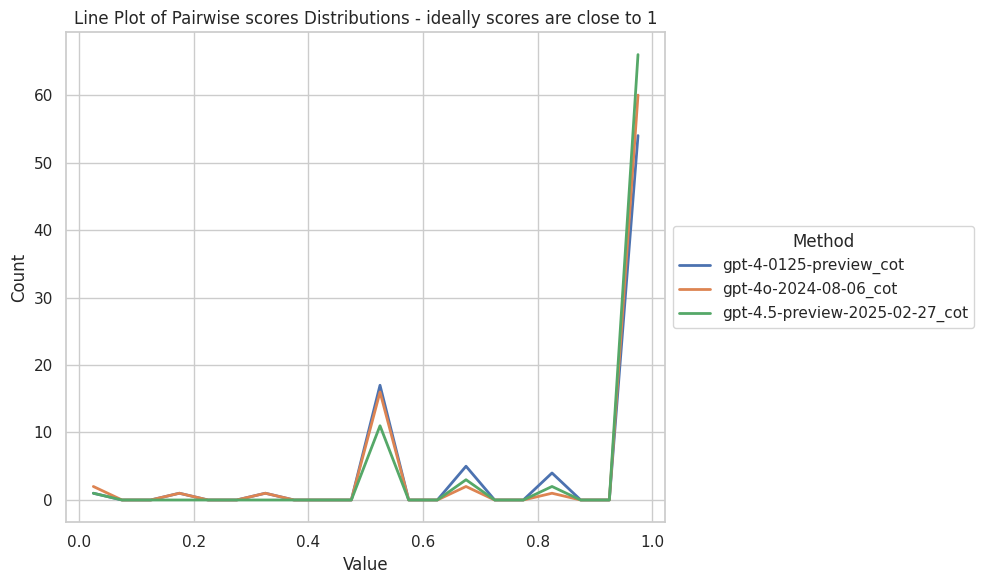

In [48]:
sub = df.loc[df.Fluency_score != 5]
columns = [
    #'gpt-4-0125-preview_pairwise', 'gpt-4o-2024-08-06_pairwise', 'gpt-4.5-preview-2025-02-27_pairwise', 
           'gpt-4-0125-preview_cot', 'gpt-4o-2024-08-06_cot','gpt-4.5-preview-2025-02-27_cot'
           ]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions for each column
for col in columns:
    # Get histogram data with raw counts (density=False)
    counts, bin_edges = np.histogram(sub[col], bins=20, density=False)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    ax.plot(bin_centers, counts, label=col, linewidth=2)  # Line plot with raw counts

# Add legend, labels, and title
ax.set_xlabel('Value')
ax.set_ylabel('Count')  # Changed from 'Density' to 'Count'
ax.set_title('Line Plot of Pairwise scores Distributions - ideally scores are close to 1')

# Place legend outside the plot
ax.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Adjust layout to make space for the legend
plt.tight_layout()

# Show the plot
plt.show()

In [49]:
df.to_csv('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv', sep=',', index=None)

In [32]:
sub.columns

Index(['source_sentence', 'target_sentence', 'source_lang', 'target_lang',
       'translations', 'Fluency_errors', 'Correction', 'Fluency_score',
       'gpt-4-0125-preview_cot', 'gpt-4o-2024-08-06_cot',
       'gpt-4.5-preview-2025-02-27_cot'],
      dtype='object')

In [ ]:


# Assuming you have a DataFrame 'df' with two text columns 'col1' and 'col2'
# Create a new column with the edit distances
df['edit_distance'] = df.apply(lambda row: Levenshtein.distance(str(row['translations']), str(row['Correction'])), axis=1)


In [50]:
df[['edit_distance', 'Fluency_score', 'gpt-4-0125-preview_cot', 'gpt-4o-2024-08-06_cot','gpt-4.5-preview-2025-02-27_cot']].corr(method='pearson')

edit_distance  Fluency_score  \
edit_distance                        1.000000      -0.688780   
Fluency_score                       -0.688780       1.000000   
gpt-4-0125-preview_cot               0.403609      -0.709536   
gpt-4o-2024-08-06_cot                0.223631      -0.542942   
gpt-4.5-preview-2025-02-27_cot       0.311642      -0.649127   

                                gpt-4-0125-preview_cot  gpt-4o-2024-08-06_cot  \
edit_distance                                 0.403609               0.223631   
Fluency_score                                -0.709536              -0.542942   
gpt-4-0125-preview_cot                        1.000000               0.803816   
gpt-4o-2024-08-06_cot                         0.803816               1.000000   
gpt-4.5-preview-2025-02-27_cot                0.804194               0.781235   

                                gpt-4.5-preview-2025-02-27_cot  
edit_distance                                         0.311642  
Fluency_score                                        -0.649127  
gpt-4-0125-preview_cot                                0.804194  
gpt-4o-2024-08-06_cot                                 0.781235  
gpt-4.5-preview-2025-02-27_cot                        1.000000

In [51]:
columns = [
    'gpt-4-0125-preview_pairwise', 'gpt-4o-2024-08-06_pairwise', 'gpt-4.5-preview-2025-02-27_pairwise', 
           'gpt-4-0125-preview_cot', 'gpt-4o-2024-08-06_cot','gpt-4.5-preview-2025-02-27_cot'
           ]

In [ ]:
# Pairwise (no COT) is slightly better than COT for all models:
df[columns].mean()

gpt-4-0125-preview_pairwise            0.766667
gpt-4o-2024-08-06_pairwise             0.800000
gpt-4.5-preview-2025-02-27_pairwise    0.835000
gpt-4-0125-preview_cot                 0.711667
gpt-4o-2024-08-06_cot                  0.781667
gpt-4.5-preview-2025-02-27_cot         0.826667
dtype: float64

# Rate translations among themselves

# Pairwise ranking
Assign a point if they agree with my fluency rating

In [ ]:


def compare_sentences_by_quality(df, id_column, sentence_column, score_column, model, cot=False, 
                               rating_prompt_func=None, save_path=None):
    """
    Compare sentences with different quality scores within the same ID group and save all ratings.
    
    Parameters:
    - df: DataFrame containing sentences and scores
    - id_column: Column name for the group identifier (source sentence)
    - sentence_column: Column name for the sentence text (translation)
    - score_column: Column name for the human quality score (1-5)
    - model: The LLM model to use for ratings
    - cot: Whether to use chain-of-thought reasoning
    - rating_prompt_func: Function that creates the rating prompt
    - save_path: Path to save the complete ratings data
    
    Returns:
    - Dictionary mapping each ID to the model's agreement rate
    - DataFrame containing all ratings data
    """
    results = {}
    all_ratings = []
    
    # Group by ID (source sentence)
    for group_id, group_df in df.groupby(id_column):
        # Initialize counters for this group
        total_comparisons = 0
        correct_comparisons = 0
        
        # Get all pairs of sentences with different quality scores
        for (_, row1), (_, row2) in tqdm(itertools.combinations(group_df.iterrows(), 2)):
            # Only compare sentences with different quality scores
            if row1[score_column] != row2[score_column]:
                total_comparisons += 1
                
                # Determine better and worse sentences based on human scores
                if row1[score_column] > row2[score_column]:
                    better_sentence = row1[sentence_column]
                    worse_sentence = row2[sentence_column]
                    better_human_score = row1[score_column]
                    worse_human_score = row2[score_column]
                    better_id = row1.name
                    worse_id = row2.name
                else:
                    better_sentence = row2[sentence_column]
                    worse_sentence = row1[sentence_column]
                    better_human_score = row2[score_column]
                    worse_human_score = row1[score_column]
                    better_id = row2.name
                    worse_id = row1.name
                
                # Get model score using the provided function
                model_score = run_rating(
                    translation=worse_sentence, 
                    correction=better_sentence, 
                    model=model, 
                    cot=cot, 
                    rating_prompt_func=rating_prompt_func or create_rating_prompt,
                    repeat=1
                )
                
                # Save all rating details
                all_ratings.append({
                    'source_id': group_id,
                    'translation_id_1': worse_id,
                    'translation_id_2': better_id,
                    'translation_1': worse_sentence,
                    'translation_2': better_sentence,
                    'human_score_1': worse_human_score,
                    'human_score_2': better_human_score,
                    'model_preference_score': model_score,
                    'model_agrees': model_score > 0.5
                })
                
                # Check if model score indicates agreement
                if model_score > 0.5:  # Assuming 0.5 as threshold, adjust if needed
                    correct_comparisons += 1
        
        # Calculate agreement rate for this group
        if total_comparisons > 0:
            agreement_rate = correct_comparisons / total_comparisons
            results[group_id] = agreement_rate
        else:
            results[group_id] = None  # No comparisons made
    
    # Convert all ratings to DataFrame
    ratings_df = pd.DataFrame(all_ratings)
    
    # Save complete ratings data if path provided
    if save_path:
        ratings_df.to_csv(save_path, index=False)
    
    return results, ratings_df

def get_top_n_translations(ratings_df, source_id=None, n=5):
    """
    Get the top N best-rated translations for each source sentence or a specific source.
    
    Parameters:
    - ratings_df: DataFrame containing all ratings data
    - source_id: Optional specific source ID to filter by
    - n: Number of top translations to return
    
    Returns:
    - DataFrame or dict of DataFrames with top translations and their scores
    """
    # Filter by source_id if specified
    if source_id:
        df = ratings_df[ratings_df['source_id'] == source_id]
    else:
        df = ratings_df.copy()
    
    # Create a scoring system for translations
    translation_scores = defaultdict(lambda: {'wins': 0, 'losses': 0, 'human_score': 0})
    
    # Count wins and losses for each translation
    for _, row in df.iterrows():
        # Translation 1 lost to Translation 2 if model_agrees is True
        if row['model_agrees']:
            translation_scores[(row['source_id'], row['translation_id_1'])]['losses'] += 1
            translation_scores[(row['source_id'], row['translation_id_2'])]['wins'] += 1
        else:
            translation_scores[(row['source_id'], row['translation_id_1'])]['wins'] += 1
            translation_scores[(row['source_id'], row['translation_id_2'])]['losses'] += 1
        
        # Store human scores
        translation_scores[(row['source_id'], row['translation_id_1'])]['human_score'] = row['human_score_1']
        translation_scores[(row['source_id'], row['translation_id_2'])]['human_score'] = row['human_score_2']
        
        # Store the actual translation text
        if 'text' not in translation_scores[(row['source_id'], row['translation_id_1'])]:
            translation_scores[(row['source_id'], row['translation_id_1'])]['text'] = row['translation_1']
        
        if 'text' not in translation_scores[(row['source_id'], row['translation_id_2'])]:
            translation_scores[(row['source_id'], row['translation_id_2'])]['text'] = row['translation_2']
    
    # Calculate a fluency score based on win/loss ratio
    results = []
    for (source_id, translation_id), data in translation_scores.items():
        total_comparisons = data['wins'] + data['losses']
        if total_comparisons > 0:
            fluency_score = data['wins'] / total_comparisons
        else:
            fluency_score = 0
            
        results.append({
            'source_id': source_id,
            'translation_id': translation_id,
            'translation': data['text'],
            'human_score': data['human_score'],
            'wins': data['wins'],
            'losses': data['losses'],
            'fluency_score': fluency_score
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Get top N for each source
    if source_id:
        return results_df.sort_values('fluency_score', ascending=False).head(n)
    else:
        top_n_by_source = {}
        for src_id, group_df in results_df.groupby('source_id'):
            top_n_by_source[src_id] = group_df.sort_values('fluency_score', ascending=False).head(n)
        return top_n_by_source

# Example usage:
# 1. Run the comparison function and save all ratings
# results, ratings_df = compare_sentences_by_quality(
#     df=translations_df,
#     id_column='source_id',
#     sentence_column='translation',
#     score_column='human_score',
#     model=model,
#     cot=True,
#     save_path='all_translation_ratings.csv'
# )
#
# 2. Get top 5 translations for source sentence with ID 'src_123'
# top_5_for_specific = get_top_n_translations(ratings_df, source_id='src_123', n=5)
#
# 3. Get top 3 translations for all source sentences
# top_3_for_all = get_top_n_translations(ratings_df, n=3)

In [94]:
all_res = {}
cot=False
models = ['gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']

for model in models:
    results = compare_sentences_by_quality(
        df, 
        id_column='source_sentence', 
        sentence_column='translations', 
        score_column='Fluency_score', 
        model=model,
        cot=cot,
        save_path=f'../data/pairwise_comparison_{model}.csv'
    )

21it [00:14,  1.40it/s]
78it [01:05,  1.20it/s]
45it [00:42,  1.05it/s]
45it [00:49,  1.10s/it]
45it [00:36,  1.22it/s]
45it [00:39,  1.13it/s]
36it [00:30,  1.18it/s]
45it [00:40,  1.11it/s]
66it [01:06,  1.01s/it]
36it [00:22,  1.57it/s]
21it [00:13,  1.58it/s]
78it [00:51,  1.53it/s]
45it [00:33,  1.34it/s]
45it [00:39,  1.13it/s]
45it [00:26,  1.70it/s]
45it [00:26,  1.69it/s]
36it [00:20,  1.73it/s]
45it [00:28,  1.60it/s]
66it [00:55,  1.19it/s]
36it [00:21,  1.69it/s]
21it [00:20,  1.03it/s]
78it [01:20,  1.04s/it]
45it [00:58,  1.31s/it]
45it [00:58,  1.30s/it]
45it [00:43,  1.03it/s]
45it [00:39,  1.13it/s]
36it [00:37,  1.03s/it]
45it [00:50,  1.13s/it]
66it [01:13,  1.11s/it]
36it [00:27,  1.30it/s]


## Can the best translation be found from pairwise comparison?

- Not too accurate. 
- Too much noise beyong p@1 
- Could maybe be improved with better comparison algorithm or more repeats
- Maybe a greedy comparison scheme

In [181]:
all_res_1 = {}
all_res_3 = {}

for model in models:
    pair = pd.read_csv(f'../data/pairwise_comparison_{model}.csv')
    rank1_res = []
    rank3_res = []
    for source_sent in pair.source_id.unique():
        sub = pair.loc[pair.source_id == source_sent]
        rank_dict = scores_to_ranks_dict(pd.concat([sub.human_score_1, sub.human_score_2]).values)
        top1 = get_top_n_translations(sub, source_id=source_sent, n=1)
        top1['human_rank'] = top1.human_score.map(lambda x: rank_dict[x])
        top3 =  get_top_n_translations(sub, source_id=source_sent, n=3)
        top3['human_rank'] = top3.human_score.map(lambda x: rank_dict[x])
        rank1_res.extend(top1.human_rank.values)
        rank3_res.extend(top3.human_rank.values)
    all_res_1[model] = rank1_res
    all_res_3[model] = rank3_res

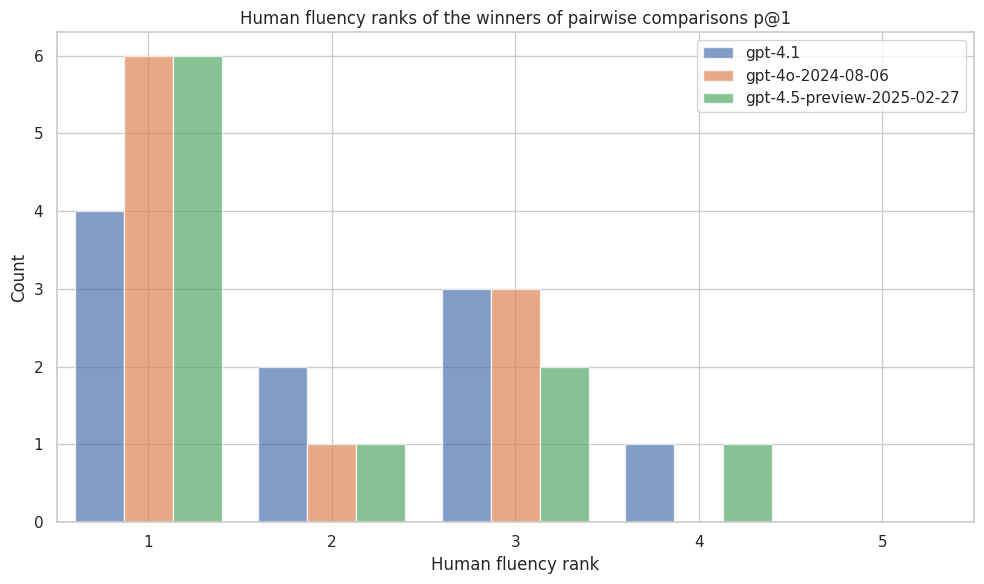

In [204]:
# Assuming all_res_1 is your data
res = pd.DataFrame(all_res_1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of pairwise comparisons p@1')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

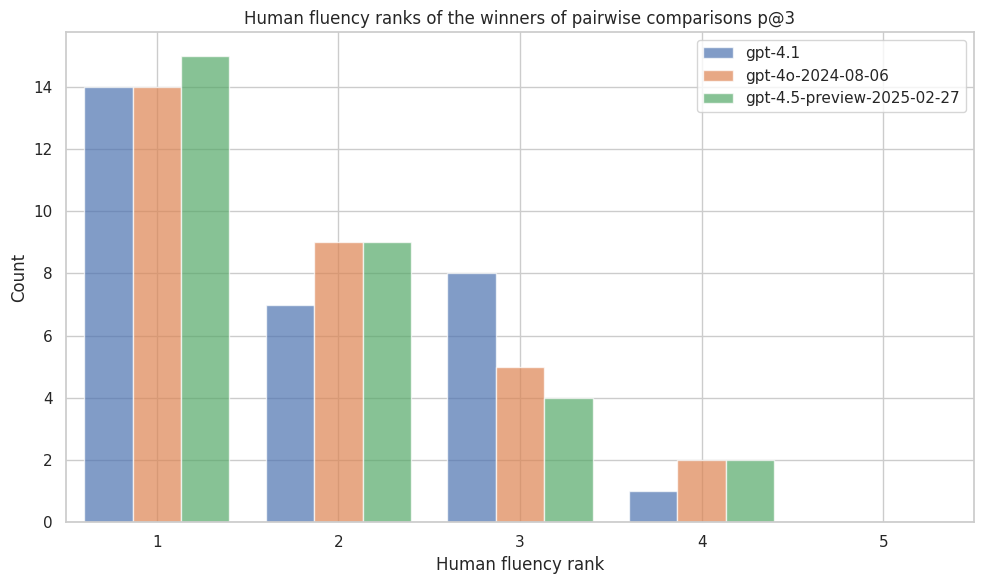

In [205]:
res = pd.DataFrame(all_res_3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of pairwise comparisons p@3')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

## Can models distinguish a dysfluent sentence from a perfectly fluent one?
- pairwise compare a dysfluent sentence with its edited counterpart
- Only the largest models can do it
- Very complex sentences have low acc
- No gain from chain of thought
- Not a key task for us - just a sanity check

<Axes: title={'center': 'Pairwise comparison of sentences with the same source sentence.\n Acc against my rating of which is better'}>

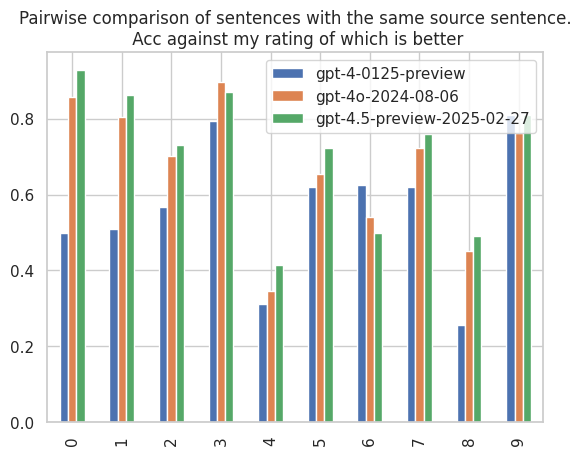

In [ ]:
pd.DataFrame(all_res).plot(kind='bar', title='Pairwise comparison of sentences with the same source sentence.\n Acc against my rating')
# Observation: The internal ranking of the models are not preserved
# There are big variations across sentences. 
# No 4 and 8 are really complex sentences.

<Axes: title={'center': 'Pairwise comparison of sentences with the same source sentence.\n Acc against my rating of which is better'}>

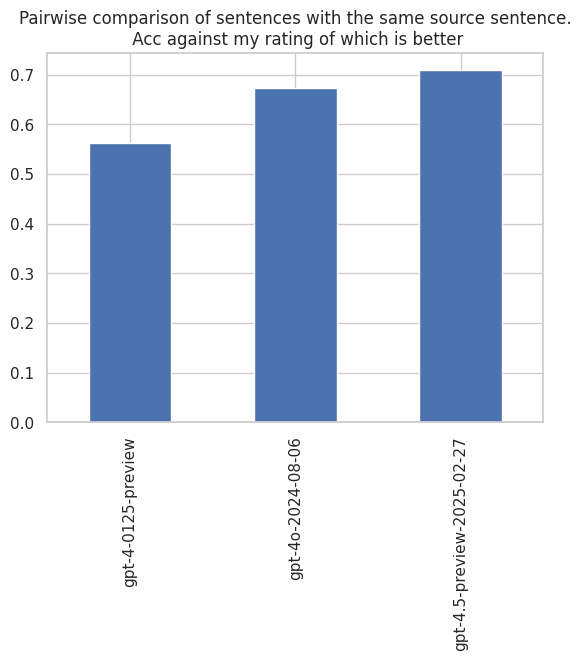

In [ ]:
pd.DataFrame(all_res).mean().plot(kind='bar', title='Pairwise comparison of sentences with the same source sentence.\n Acc against my rating of which is better')

## Batch ranking
Rank all 10 sentences and compare the rank with my ranking

In [12]:
def get_llm_rankings(translations, model, max_completion_tokens, cot=False):
    """Get LLM rankings for a list of translations of the same source."""
    # Construct prompt
    prompt_no_cot = f"""
    
    Please rank the following sentences from best to worst (1 = best) according to how fluent they are to a native Danish speaker:
    {chr(10).join([f"{i+1}. {t}" for i, t in enumerate(translations)])}
    
    Provide your rankings as a comma-separated list of numbers corresponding to the translation numbers above between <rankings> </rankings> tags.
    """

    prompt_cot = f"""
    Please rank the following sentences from best to worst (1 = best) according to how fluent they are to a native Danish speaker:
    {chr(10).join([f"{i+1}. {t}" for i, t in enumerate(translations)])}
    Provide an evaluation of the fluency for each  your ranking between <reasoning> </reasoning> tags that violates a perfect fluency that is defined like:     Grammar: Perfect grammatical control with no errors in noun gender, verb conjugation, or word order
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions. 
    Example <reasoning>1: fluency errors when using anglicism 'tale op' and this word does not exist in Danish: 'nedsk√∏rings' 2: wrong subject-verb ordering in a subclause ... </reasoning>: 
    Provide your rankings as a comma-separated list of indices corresponding to the translation numbers above between <rankings> </rankings> tags.
    """
    if cot:
        prompt = prompt_cot
    else:
        prompt = prompt_no_cot
    
    # Get response from LLM
    response = call_litellm(prompt, model=model, max_completion_tokens=max_completion_tokens)
    
    # Extract just the numbers from the response
    rankings = BeautifulSoup(response, 'html.parser').find('rankings').text 
    rankings_list = [int(x.strip()) for x in rankings.strip().split(',')]
        
    return rankings_list

def sort_by_llm_and_get_top_n(llm_rankings, human_rankings, n=3):
    # Pair the rankings
    paired_rankings = list(zip(llm_rankings, human_rankings))
    
    # Sort the pairs based on llm_rankings (first element in each pair)
    # Using reverse=True to sort in descending order (higher ranking first)
    sorted_pairs = sorted(paired_rankings, key=lambda x: x[0], reverse=False)
    
    # Take the top n pairs
    top_n_pairs = sorted_pairs[:n]
    
    # Unzip the pairs back into separate lists
    _top_n_llm, top_n_human = zip(*top_n_pairs) if top_n_pairs else ([], [])
    
    return list(top_n_human)

# Process each source sentence

cot = True
all_res_batch_1 = {}
all_res_batch_3 = {}
models = ['gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
for model in models:
    top3s = []
    top1s = []
    for source, group in df.groupby('source_sentence'):
        translations = group['translations'].tolist()
        human_ratings = group['Fluency_score'].tolist()
        
        # Get human rankings (higher rating = better rank)
        rank_dict = scores_to_ranks_dict(human_ratings)
        human_rankings = [rank_dict[x] for x in human_ratings]
        
        # Get LLM rankings
        llm_rankings = get_llm_rankings(translations, model=model, max_completion_tokens=200)
        top3 = sort_by_llm_and_get_top_n(llm_rankings=llm_rankings, human_rankings=human_rankings)
        top1 = top3[0]
        top3s.extend(top3)
        top1s.extend([top1])

    all_res_batch_1[model] = top1s
    all_res_batch_3[model] = top3s

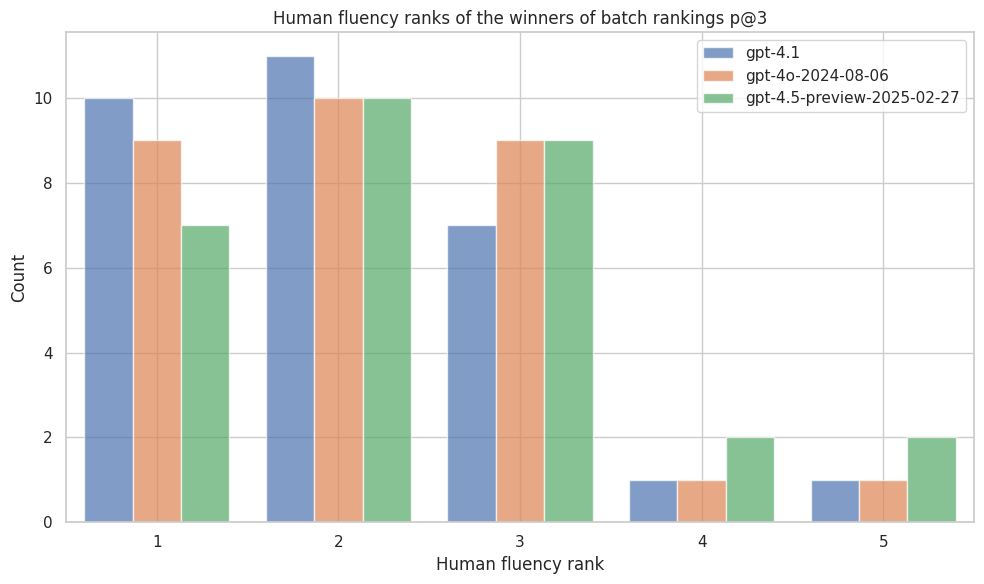

In [13]:
res = pd.DataFrame(all_res_batch_3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of batch rankings p@3')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

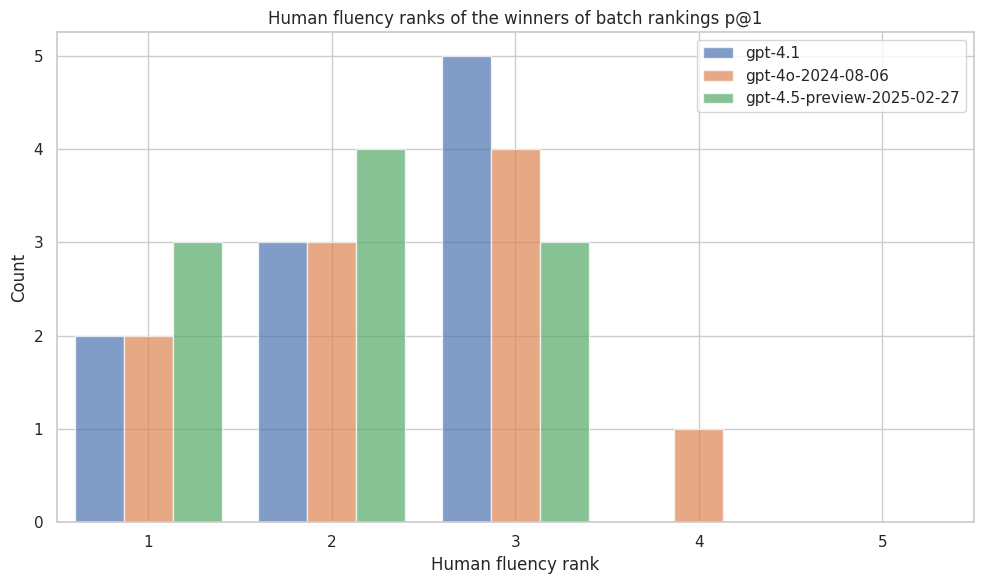

In [10]:
res = pd.DataFrame(all_res_batch_1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of batch rankings p@1')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

# Scoring
Can an LLM score the fluency similarly to a human?

Observations
- It seems to require substantial model size, but it seems to work reasonaby well
- - GPT4 4.5 and GPT 4.1 have the same mean squared error (0.95) and both show medium strenght correlation with my scores, but GPT 4.5 has a higher correlation (.59)
- The confusion matrix shows that classes are most often mixed with neighboring classes which is pleasing 

In [ ]:

for model in ['gpt-4.1-mini']:
    #df[f'{model}_fluency_score'] = df['translations'].progress_map(lambda x: call_litellm(create_prompt_rating(x), model, max_completion_tokens=1000))
    #df[f'{model}_fluency_score_score'] = df[f'{model}_fluency_score'].map(lambda x:  BeautifulSoup(x, 'html.parser').find('score').text.strip() if BeautifulSoup(x, 'html.parser').find('score') else None)
    #df[f'{model}_fluency_score_score'].fillna(0, inplace=True)
    df[f'{model}_fluency_score_SE'] = (df.Fluency_score - df[f'{model}_fluency_score_score'].astype(int))**2

In [108]:
# Mean squared error
models = ['gpt-4.1-nano', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-mini']
for model in models:
    sub = df.loc[df[f'{model}_fluency_score_SE'] > 0]
    print(model, 'MSE: ', mean_squared_error(y_true=sub['Fluency_score'], y_pred=sub[f'{model}_fluency_score_score']))

gpt-4.1-nano MSE:  2.2903225806451615
gpt-4.1 MSE:  1.6964285714285714
gpt-4o-2024-08-06 MSE:  3.0
gpt-4.5-preview-2025-02-27 MSE:  1.6666666666666667
gpt-4.1-mini MSE:  1.9423076923076923


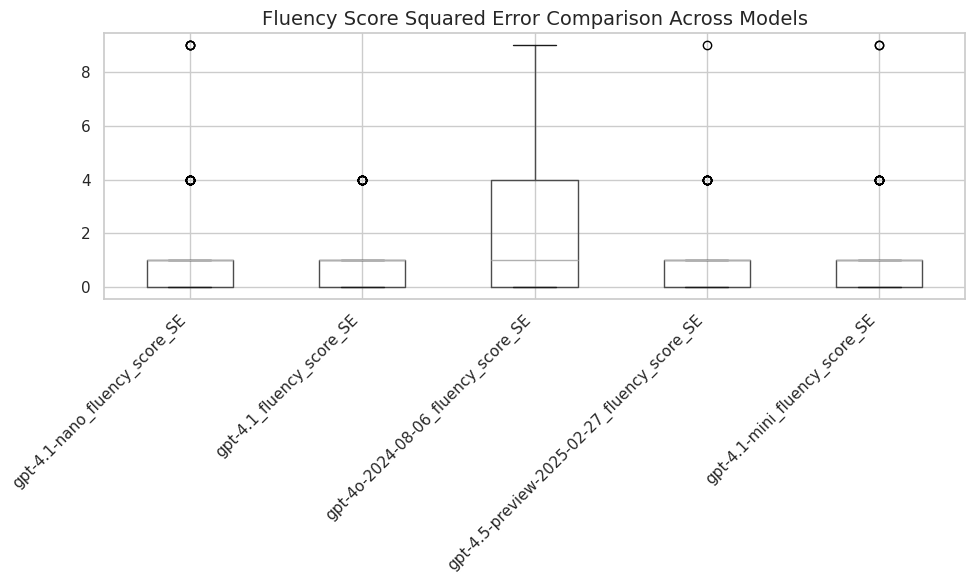

In [105]:

fig, ax = plt.subplots(figsize=(10, 6))  # Create figure with custom size
df[[f'{m}_fluency_score_SE' for m in models]].boxplot(ax=ax)
plt.xticks(rotation=45, ha='right')  # Rotate by 45 degrees, horizontally align to right
plt.title('Fluency Score Squared Error Comparison Across Models', fontsize=14)
plt.tight_layout()
plt.show()

In [115]:
# Correlation between human fluency score and model fluency scores
plot_df = df[['Fluency_score'] + [f'{m}_fluency_score_score' for m in models]].copy().astype(int)
plot_df = plot_df.loc[plot_df['gpt-4.1-mini_fluency_score_score'] != 0]
plot_df.corr(method='pearson')['Fluency_score']

Fluency_score                                     1.000000
gpt-4.1-nano_fluency_score_score                  0.312416
gpt-4.1_fluency_score_score                       0.559100
gpt-4o-2024-08-06_fluency_score_score             0.459445
gpt-4.5-preview-2025-02-27_fluency_score_score    0.602623
gpt-4.1-mini_fluency_score_score                  0.601566
Name: Fluency_score, dtype: float64

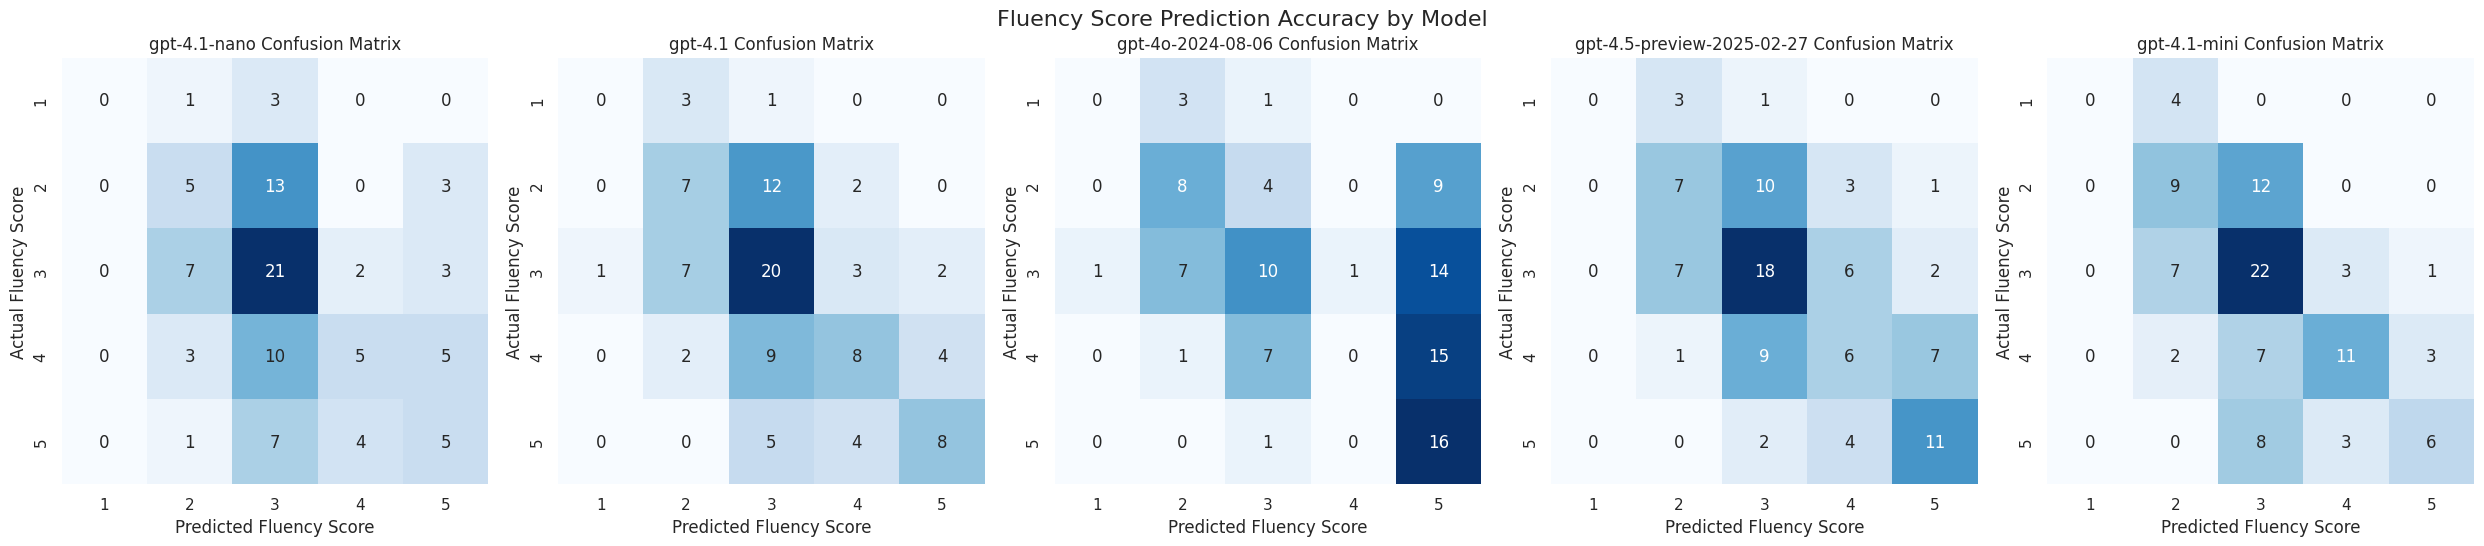

In [116]:
# Create a function to generate confusion matrices
def plot_confusion_matrices(df, models):
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 5))
    
    if len(models) == 1:
        axes = [axes]  # Make it iterable if there's only one model
    
    for i, model in enumerate(models):
        model_col = f"{model}_fluency_score_score"
        
        # Create a confusion matrix (true scores vs. predicted scores)
        conf_matrix = pd.crosstab(
            df['Fluency_score'], 
            df[model_col],
            rownames=['Actual'],
            colnames=['Predicted'],
            dropna=False
        )
        
        # Fill in missing values in the matrix with zeros
        for score in range(1, 6):
            if score not in conf_matrix.index:
                conf_matrix.loc[score] = 0
            if score not in conf_matrix.columns:
                conf_matrix[score] = 0
        
        # Sort the indices and columns
        conf_matrix = conf_matrix.sort_index().sort_index(axis=1)
        
        # Plot the confusion matrix
        sns.heatmap(
            conf_matrix, 
            annot=True, 
            fmt='d',
            cmap='Blues',
            ax=axes[i],
            cbar=False,
            square=True
        )
        
        axes[i].set_title(f'{model} Confusion Matrix')
        axes[i].set_xlabel('Predicted Fluency Score')
        axes[i].set_ylabel('Actual Fluency Score')
        
        # Ensure both axes show all values from 1-5
        axes[i].set_xticks(np.arange(0.5, 5.5))
        axes[i].set_yticks(np.arange(0.5, 5.5))
        axes[i].set_xticklabels(range(1, 6))
        axes[i].set_yticklabels(range(1, 6))

    plt.tight_layout()
    plt.suptitle("Fluency Score Prediction Accuracy by Model", fontsize=16, y=1.05)
    
    return fig

# Create the confusion matrices
fig = plot_confusion_matrices(plot_df, models)
plt.show()

# Editing
Can models edit a dysfluent sentence to a fluent one?

- GPT 4.1 edit the sentences reasonably well and preserve the order between mini and nano
- cot does not make a difference
- GPT 4.5 is better is 4.1, but sometimes do not follow instructions and returns an English sentence

In [ ]:
def create_edit_prompt(translation, model, max_completion_tokens, cot=False):

    # Construct prompt
    prompt_no_cot = f"""
    Edit this sentence such that it becomes fluent to a native speaker. Make all the necessary edits, but nothing more than that.
    Return the edited sentence between these tags: <edited_sentence> </edited_sentence>
    <original_sentence>{translation}</original_sentence>
    """
    
    prompt_cot = f"""
    List all the spans that are not fully fluent to a native speaker, whether it be lexical, grammatical, idiomatic, or cultural knowledge errors between these tags: <dysfluent_span> </dysfluent_span>
    Edit this sentence such that it becomes fluent to a native speaker. Make all the necessary edits, but nothing more than that.
    Return the edited sentence between these tags <edited_sentence> </edited_sentence>
    <original_sentence>{translation}</original_sentence>
    """
    if cot:
        prompt = prompt_cot
    else:
        prompt = prompt_no_cot
    
     # Get response from LLM
    response = call_litellm(prompt, model=model, max_completion_tokens=max_completion_tokens)
    
    # Extract just the numbers from the response
    try:
        edited_sentence = BeautifulSoup(response, 'html.parser').find('edited_sentence').text 
    except AttributeError:
        print(response)
        edited_sentence = None

    return edited_sentence
    

In [146]:
models = ['gpt-4.1-nano', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-mini']
for model in models:
    #df[f'{model}_edited_sentence_cot'] = df.translations.progress_map(lambda x: create_edit_prompt(translation=x, model=model, max_completion_tokens=1000, cot=True))
    df[f'{model}_edited_sentence'] = df.translations.progress_map(lambda x: create_edit_prompt(translation=x, model=model, max_completion_tokens=1000, cot=False))

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [03:10<00:00,  1.91s/it]


In [ ]:
# Add all corrections for the source sentence to a column named 'references' to get multiple references for each source sentence

grouped = df.groupby('source_sentence')['Correction'].apply(list).reset_index()
grouped = grouped.rename(columns={'Correction': 'references'})

# If you want to merge this back to the original df to add the references column
# First create a dictionary mapping source_sentence to references
reference_dict = dict(zip(grouped['source_sentence'], grouped['references']))

# Then add a new column to the original df
df['references'] = df['source_sentence'].map(reference_dict)

#Also add the target sentence

df['references'] = df.apply(
     lambda row: row['references'] + [row['target_sentence']] 
     if isinstance(row['references'], list) and row['target_sentence'] not in row['references']
     else [row['target_sentence']] if not isinstance(row['references'], list)
     else row['references'],
     axis=1
 )


In [159]:
# calculate the BLEU score
models = ['gpt-4.1-nano', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-mini']
bleu = BLEU
for model in models:
    df[f'{model}_cot_BLEU'] = df.progress_apply(lambda x: sacrebleu.compute(predictions=[x[f'{model}_edited_sentence_cot']], references=[x['references']])['score'], axis=1)
    df[f'{model}_BLEU'] = df.progress_apply(lambda x: sacrebleu.compute(predictions=[x[f'{model}_edited_sentence']], references=[x['references']])['score'], axis=1)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:02<00:00, 42.86it/s]


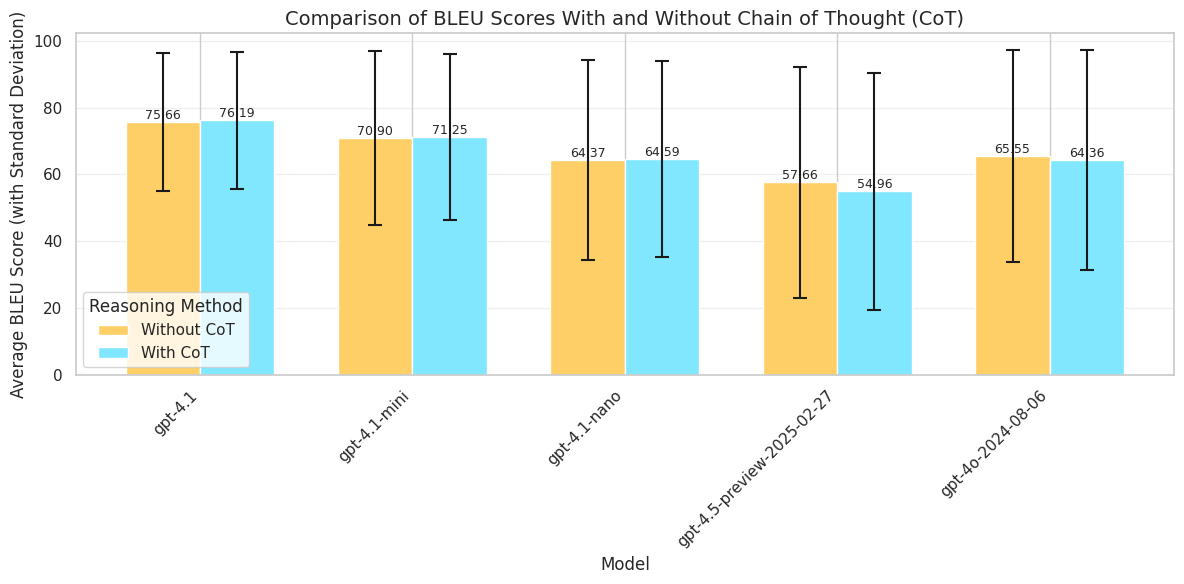

In [172]:
def plot_bleu_comparison(df):
    # Extract model names by looking at column names
    columns = df.columns
    model_names = set(models)
    
    # Prepare data for plotting
    plot_data = []
    
    for model in model_names:
        # Get mean and std BLEU scores (with and without CoT)
        bleu_no_cot_mean = df[f'{model}_BLEU'].mean()
        bleu_no_cot_std = df[f'{model}_BLEU'].std()
        
        bleu_cot_mean = df[f'{model}_cot_BLEU'].mean()
        bleu_cot_std = df[f'{model}_cot_BLEU'].std()
        
        # Add to data list
        plot_data.append({
            'Model': model, 
            'Method': 'Without CoT', 
            'BLEU': bleu_no_cot_mean,
            'BLEU_std': bleu_no_cot_std
        })
        plot_data.append({
            'Model': model, 
            'Method': 'With CoT', 
            'BLEU': bleu_cot_mean,
            'BLEU_std': bleu_cot_std
        })
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Create custom barplot with error bars
    ax = plt.subplot(111)
    
    # Get unique methods and models for positioning
    methods = plot_df['Method'].unique()
    models_list = sorted(list(model_names))
    
    # Set width of bars
    bar_width = 0.35
    
    # Set positions on x-axis
    positions = np.arange(len(models_list))
    
    # Plot bars with error bars
    for i, method in enumerate(methods):
        method_data = plot_df[plot_df['Method'] == method]
        
        # Align bars side by side
        offset = (i - 0.5) * bar_width
        
        # Get colors from viridis palette
        colors = plt.cm.managua(np.linspace(0, 1, len(methods)))
        
        # Plot bars with error bars
        bars = ax.bar(
            positions + offset, 
            method_data['BLEU'], 
            width=bar_width,
            yerr=method_data['BLEU_std'],
            label=method,
            color=colors[i],
            capsize=5,  # Cap width for error bars
            error_kw={'elinewidth': 1.5, 'capthick': 1.5}  # Error bar style
        )
        
        # Add value labels on top of bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.01,
                f'{height:.2f}',
                ha='center', 
                va='bottom',
                fontsize=9
            )
    
    # Set x-ticks at the center of grouped bars
    ax.set_xticks(positions)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    
    # Enhance the plot
    plt.title('Comparison of BLEU Scores With and Without Chain of Thought (CoT)', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Average BLEU Score (with Standard Deviation)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # Improve legend
    plt.legend(title='Reasoning Method', loc='best')
    
    plt.tight_layout()
    return plt.gcf()

# Call the function
fig = plot_bleu_comparison(df)
plt.show()

In [177]:
import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-3B-Instruct"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]
outputs = pipe(
    messages,
    max_new_tokens=256,
)
print(outputs[0]["generated_text"][-1])

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


KeyboardInterrupt: 